In [97]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [98]:
np.random.seed(45)
num_samples = 40

# Generate data
x1 = np.random.uniform(-1, 1, num_samples)
f_x = 3*x1 + 4
eps = np.random.randn(num_samples)
y = f_x + eps




### 1. Use torch.autograd to find the true gradient on the above dataset using ### linear regression (in the form θ1x+θ0) for any given values of (θ0,θ1).

In [99]:

# Set seed for reproducibility
torch.manual_seed(42)

# Convert to PyTorch tensors
x1_torch = torch.tensor(x1, dtype=torch.float32).view(-1, 1)
y_torch = torch.tensor(y, dtype=torch.float32).view(-1, 1)


# Define the linear model using nn.Linear
model = nn.Linear(1, 1)  # Input features = 1, Output features = 1

# Define the loss function
criterion = nn.MSELoss()

# Get parameters
params = list(model.parameters())
theta_0 = params[0]  # Bias (θ0)
theta_1 = params[1]  # Weight (θ1)

print(theta_0)
print(theta_1)
print("\n")

# Compute the true gradient
def compute_true_gradient(model, x, y, criterion):
    model.zero_grad()  # Clear previous gradients
    y_pred = model(x)  # Forward pass
    loss = criterion(y_pred, y)  # Compute loss
    loss.backward()  # Backward pass to compute gradients
    grad_theta_0_true = model.bias.grad.item()  # Gradient for bias
    grad_theta_1_true = model.weight.grad.item()  # Gradient for weight
    return grad_theta_0_true, grad_theta_1_true

# Compute true gradients
grad_theta_0_true, grad_theta_1_true = compute_true_gradient(model, x1_torch, y_torch, criterion)

print(theta_0)
print(theta_1)
print("\n")

# Print the gradients
print(f"True Gradient of θ0 (bias): {grad_theta_0_true}")
print(f"True Gradient of θ1 (weight): {grad_theta_1_true}")



Parameter containing:
tensor([[0.7645]], requires_grad=True)
Parameter containing:
tensor([0.8300], requires_grad=True)


Parameter containing:
tensor([[0.7645]], requires_grad=True)
Parameter containing:
tensor([0.8300], requires_grad=True)


True Gradient of θ0 (bias): -5.916536331176758
True Gradient of θ1 (weight): -0.6829416155815125


### 2.Using the same (θ0,θ1)as above, calculate the stochastic gradient for all points in the dataset. Then, find the average of all those gradients and show that the stochastic gradient is a good estimate of the true gradient.

In [100]:
# Calculate stochastic gradients
stochastic_grads_theta_0 = []
stochastic_grads_theta_1 = []

for param in model.parameters():
      print(param.view(-1))
print("\n")

for i in range(len(x1_torch)):
    xi = x1_torch[i].view(1, -1)
    yi = y_torch[i].view(1, -1)

    model.zero_grad()  # Clear previous gradients
    y_pred = model(xi)  # Forward pass
    loss = criterion(y_pred, yi)  # Compute loss
    loss.backward()  # Backward pass to compute gradients

    grad_theta_0_stochastic = model.bias.grad.item()  # Gradient for bias
    grad_theta_1_stochastic = model.weight.grad.item()  # Gradient for weight

    stochastic_grads_theta_0.append(grad_theta_0_stochastic)
    stochastic_grads_theta_1.append(grad_theta_1_stochastic)

# Compute average stochastic gradients
avg_grad_theta_0_stochastic = sum(stochastic_grads_theta_0) / len(stochastic_grads_theta_0)
avg_grad_theta_1_stochastic = sum(stochastic_grads_theta_1) / len(stochastic_grads_theta_1)

# Print the results
print(f"True Gradient of θ0 (bias): {grad_theta_0_true}")
print(f"True Gradient of θ1 (weight): {grad_theta_1_true}")
print("\n")
print(f"Average Stochastic Gradient of θ0 (bias): {avg_grad_theta_0_stochastic}")
print(f"Average Stochastic Gradient of θ1 (weight): {avg_grad_theta_1_stochastic}")

tensor([0.7645], grad_fn=<ViewBackward0>)
tensor([0.8300], grad_fn=<ViewBackward0>)


True Gradient of θ0 (bias): -5.916536331176758
True Gradient of θ1 (weight): -0.6829416155815125


Average Stochastic Gradient of θ0 (bias): -5.916536408662796
Average Stochastic Gradient of θ1 (weight): -0.6829415835440159


The values of average of all stochastic gradients and true gradients is nearly same. So tochastic gradient is a good estimate of the true gradient.

### 3. Implement full-batch, mini-batch and stochastic gradient descent. Calculate the average number of iterations required for each method to get sufficiently close to the optimal solution, where "sufficiently close" means within a distance of ϵ(or ϵ-neighborhood) from the minimum value of the loss function. Visualize the convergence process for 15 epochs. Choose ϵ=0.001for convergence criteria. Which optimization process takes a larger number of epochs to converge, and why? Show the contour plots for different epochs (or show an animation/GIF) for visualisation of optimisation process. Also, make a plot for Loss v/s epochs for all the methods.

In [101]:
torch.manual_seed(42)
# Define the full-batch gradient descent function using nn modules
def full_batch_gd(x, y, lr=0.1, epochs=106, epsilon=0.001):
    # Initialize linear model using nn.Linear
    model = nn.Linear(1, 1, bias=True)

    print("Current Parameters:")
    for param in model.parameters():
      print(param.view(-1))
    print("\n")

    # Initialize the loss function
    criterion = nn.MSELoss()

    # Initialize optimizer for updating model parameters
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    # History lists for storing theta values and loss
    theta_0_history = []
    theta_1_history = []
    loss_history = []

    for epoch in range(epochs):
        # Forward pass
        y_pred = model(x)
        loss = criterion(y_pred, y)

        # Backward pass (compute gradients)
        optimizer.zero_grad()  # Zero the gradients
        loss.backward()      # Compute gradients

        # Update parameters
        optimizer.step()       # Update model parameters

        # Record the parameters (weights and bias)
        with torch.no_grad():
            theta_0_history.append(model.bias.item())
            theta_1_history.append(model.weight.item())

        # Record the loss
        loss_history.append(loss.item())

        # Check for convergence

        if loss.item() < epsilon:
            break

    return theta_0_history, theta_1_history, loss_history

# Example usage (assuming x1_torch and y_torch are already defined):
theta_0_history_full, theta_1_history_full, loss_history_full = full_batch_gd(x1_torch, y_torch)
print(f"No of epochs executed:", len(loss_history_full))
print("\n")

print("The losses for all epochs till convergence are:")
for i in range(len(loss_history_full)):
  print(f"loss at epoch{i+1} is", loss_history_full[i])

Current Parameters:
tensor([0.7645], grad_fn=<ViewBackward0>)
tensor([0.8300], grad_fn=<ViewBackward0>)


No of epochs executed: 106


The losses for all epochs till convergence are:
loss at epoch1 is 10.482534408569336
loss at epoch2 is 7.280035972595215
loss at epoch3 is 5.194877624511719
loss at epoch4 is 3.8265929222106934
loss at epoch5 is 2.919559955596924
loss at epoch6 is 2.3104519844055176
loss at epoch7 is 1.8947769403457642
loss at epoch8 is 1.605560302734375
loss at epoch9 is 1.3997691869735718
loss at epoch10 is 1.2496594190597534
loss at epoch11 is 1.1372628211975098
loss at epoch12 is 1.0508711338043213
loss at epoch13 is 0.9827934503555298
loss at epoch14 is 0.9279249906539917
loss at epoch15 is 0.8828320503234863
loss at epoch16 is 0.845166802406311
loss at epoch17 is 0.8132914304733276
loss at epoch18 is 0.7860376834869385
loss at epoch19 is 0.7625511884689331
loss at epoch20 is 0.7421897649765015
loss at epoch21 is 0.7244588136672974
loss at epoch22 is 0.708967447280

Here, the full batch gradient descent is done for all 106 epochs which means the loss didnt converge to given neighbourhood of 0.001 for all 106 epochs. The plateaued loss value is 0.5957 which was achieved at epoch 84.

In [102]:
torch.manual_seed(42)

# Create dataset
dataset = CustomDataset(x1_torch, y_torch)

def mini_batch_gd(x, y, batch_size=12, lr=0.1, epochs=150, epsilon=0.001):

    # Initialize linear model using nn.Linear
    model = nn.Linear(1, 1, bias=True)

    # Initialize loss function (MSE)
    criterion = nn.MSELoss()

    print("Current Parameters:")
    for param in model.parameters():
      print(param.view(-1))
    print("\n")

    # Initialize optimizer for updating model parameters
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    # History lists for storing theta values and loss
    theta_0_history = []
    theta_1_history = []
    loss_history = []

    # num_batches = int(np.ceil(len(x) / batch_size))

    for epoch in range(epochs):
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        for x_batch, y_batch in dataloader:

            # Forward pass
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)



            # Backward pass (compute gradients)
            optimizer.zero_grad()  # Zero the gradients
            loss.backward()        # Compute gradients

            # Update parameters
            optimizer.step()       # Update model parameters


        # Record loss history and parameters after each epoch
        with torch.no_grad():
            y_pred_full = model(x)  # Predict for the full dataset
            full_loss = criterion(y_pred_full, y)  # Calculate full loss
            loss_history.append(full_loss.item())

            # Record the parameters (weights and bias)
            theta_0_history.append(model.bias.item())
            theta_1_history.append(model.weight.item())

        # Check for convergence
        if full_loss.item() < epsilon:
            break

    return theta_0_history, theta_1_history, loss_history

# Example usage (assuming x1_torch and y_torch are already defined):
theta_0_history_mini, theta_1_history_mini, loss_history_mini = mini_batch_gd(x1_torch, y_torch)

print(f"No of epochs executed:", len(loss_history_mini))
print("\n")

print("The losses for all epochs till convergence are:")
for i in range(len(loss_history_mini)):
  print(f"loss at epoch{i+1} is", loss_history_mini[i])

Current Parameters:
tensor([0.7645], grad_fn=<ViewBackward0>)
tensor([0.8300], grad_fn=<ViewBackward0>)


No of epochs executed: 150


The losses for all epochs till convergence are:
loss at epoch1 is 3.0422143936157227
loss at epoch2 is 1.4531930685043335
loss at epoch3 is 1.0368216037750244
loss at epoch4 is 0.8552805185317993
loss at epoch5 is 0.7875229120254517
loss at epoch6 is 0.6636717915534973
loss at epoch7 is 0.6357796788215637
loss at epoch8 is 0.6209077835083008
loss at epoch9 is 0.616369366645813
loss at epoch10 is 0.609606146812439
loss at epoch11 is 0.6012169718742371
loss at epoch12 is 0.5982301831245422
loss at epoch13 is 0.6041463017463684
loss at epoch14 is 0.5981142520904541
loss at epoch15 is 0.5986132025718689
loss at epoch16 is 0.5987789034843445
loss at epoch17 is 0.597187340259552
loss at epoch18 is 0.5959261655807495
loss at epoch19 is 0.6054754257202148
loss at epoch20 is 0.5961759686470032
loss at epoch21 is 0.6010051965713501
loss at epoch22 is 0.6200821995

Here, the mini batch gradient descent is done for all 150 epochs which means the loss didnt converge to given neighbourhood of 0.001 for all 150 epochs. Here the loss is oscillating a little due to high variance. The loss generated after 106 epochs of full batch gradient descent is generated by mini batch approximaely at only 50th epoch. So we can say that loss by mini batch gradient descent converges faster compared to full batch. This is because parameter updates ate made frequently rather than going through entire batch. So time required is less and hence converges faster.

In [103]:
torch.manual_seed(42)

# Create dataset
dataset = CustomDataset(x1_torch, y_torch)


# Define the stochastic gradient descent function using nn modules
def stochastic_gd(x, y, batch_size=1, lr=0.1, epochs=180, epsilon=0.001):
    # Initialize linear model using nn.Linear
    model = nn.Linear(1, 1, bias=True)

    # Initialize the loss function
    criterion = nn.MSELoss()

    # Initialize the optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    # History lists for storing theta values and loss
    theta_0_history = []
    theta_1_history = []
    loss_history = []

    for epoch in range(epochs):
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        for x_batch, y_batch in dataloader:

            # Forward pass
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)



            # Backward pass (compute gradients)
            optimizer.zero_grad()  # Zero the gradients
            loss.backward()        # Compute gradients

            # Update parameters
            optimizer.step()       # Update model parameters

        # Record loss and parameter histories after each epoch
        with torch.no_grad():
            y_pred_full = model(x)  # Full dataset prediction
            full_loss = criterion(y_pred_full, y)
            loss_history.append(full_loss.item())

            # Extract theta_0 (bias) and theta_1 (weight)
            theta_0_history.append(model.bias.item())
            theta_1_history.append(model.weight.item())

        # Check for convergence
        if full_loss.item() < epsilon:
            break

    return theta_0_history, theta_1_history, loss_history

# Example usage (assuming x1_torch and y_torch are already defined):
theta_0_history_stoch, theta_1_history_stoch, loss_history_stoch = stochastic_gd(x1_torch, y_torch)


print(f"No of epochs executed:", len(loss_history_stoch))
print("\n")

print("The losses for all epochs till convergence are:")
for i in range(len(loss_history_stoch)):
  print(f"loss at epoch{i+1} is", loss_history_stoch[i])


No of epochs executed: 180


The losses for all epochs till convergence are:
loss at epoch1 is 0.606484591960907
loss at epoch2 is 0.6038659811019897
loss at epoch3 is 0.7564143538475037
loss at epoch4 is 0.6054728031158447
loss at epoch5 is 0.8568671941757202
loss at epoch6 is 0.6386058926582336
loss at epoch7 is 0.7766932249069214
loss at epoch8 is 0.6067849397659302
loss at epoch9 is 0.5984352827072144
loss at epoch10 is 0.601024866104126
loss at epoch11 is 0.6728137731552124
loss at epoch12 is 0.5972989797592163
loss at epoch13 is 0.6507421135902405
loss at epoch14 is 0.6037634015083313
loss at epoch15 is 0.5978843569755554
loss at epoch16 is 0.6616504192352295
loss at epoch17 is 0.6005462408065796
loss at epoch18 is 0.6407588720321655
loss at epoch19 is 0.6819469332695007
loss at epoch20 is 0.6517277359962463
loss at epoch21 is 0.6200437545776367
loss at epoch22 is 0.7102785706520081
loss at epoch23 is 0.7168191075325012
loss at epoch24 is 0.863442599773407
loss at epoch25 is 0.62

Here the loss values are oscillating on a large scale due to high variance. The loss didnt reach its plateauing value even for 180 epochs. This says that loss by stochastic gradient descent converges for large number of epochs compared to full batch and mini batch gradient descent.

Here, the stochastic gradient descent is done for all 180 epochs which means the loss didnt converge to given neighbourhood of 0.001 for all 180 epochs. Here the loss is oscillating noticebly due to high variance. The loss generated after 106 epochs of full batch gradient descent is generated by stochastic gradient descent approximaely at only 9th epoch. So we can say that loss by stochastic gradient descent converges faster compared to full batch and mini batch varients. This is because parameter updates ate made frequently i.e, for every sample rather than going through entire batch. So time required is less and hence converges faster.


In my case, any of the gradient descent methods are not converging ϵ-neighborhood but in general, , stochastic gradient descent (SGD) takes less epochs to converge compared to full-batch gradient descent or  mini batch gardient descent.

Because SGD computes the gradient for each sample, or mini-batch, instead of waiting for the complete dataset like Full-Batch Gradient Descent does, it updates parameters more often. Converging is accelerated by these frequent updates, particularly during the early phases of training.

Computing the gradient throughout the whole dataset is computationally expensive for large datasets. SGD, on the other hand, requires less computing power per iteration because it only needs to compute the gradient for one sample at each step. This implies that more changes can be completed in the same time frame.

Whereas full batch gradient descent takes longest time to converge as it updatesthe parameters after going through the entire dataset which takes much time and is computationally expensive in terms of time and memory.

Mini batch gradient descent converges sooner than full abtch but loneger than stochastic as it updates its parameters after going through limited number of samples.

But,
SGD adjusts the model parameters using one sample of data, which results in high variance. The model tries to fit exactly over that one sample(high variance). This causes more oscillations during optimization while keeping the process from being trapped in local minima. Consequently, the optimization route becomes non-smooth.

A more reliable update direction is given by full-batch gradient descent, also known as gradient descent, which computes the gradient using the complete dataset. This often creates a more constant and smooth convergence.

Mini batch gardient descent causes less oscillations during optimisation compared to stochastic but more than full batch gradient descent.

In [104]:
import matplotlib.animation as animation
def contour_plot_animation(theta_0_history, theta_1_history, x, y, save_dir='animations', file='optimization_path.gif', num_epochs=15,levels = 20):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Convert inputs to numpy for contour plotting
    x_np = x.numpy().flatten()
    y_np = y.numpy().flatten()

    # Generate grid points for theta_0 and theta_1
    t0 = np.linspace(-1, 7, 100)
    t1 = np.linspace(-1, 7, 100)
    T0, T1 = np.meshgrid(t0, t1)

    Z = np.zeros_like(T0)

    # Compute loss over the grid
    criterion = torch.nn.MSELoss()
    for i in range(len(t0)):
        for j in range(len(t1)):
            theta_0 = T0[i, j]
            theta_1 = T1[i, j]
            y_pred = theta_1 * torch.tensor(x_np, dtype=torch.float32) + theta_0
            loss = criterion(y_pred, torch.tensor(y_np, dtype=torch.float32))
            Z[i, j] = loss.item()

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Create contour plot
    contour = ax.contourf(T0, T1, Z, levels, cmap='viridis')
    fig.colorbar(contour, label='Loss')

    # Initialize line for optimization path
    path_line, = ax.plot([], [], color='white', marker='o', linestyle='-', markersize=2, lw=0.7)

    # Update function for the animation
    def update(epoch):
        # Limit the update to the first `num_epochs` epochs
        if epoch < len(theta_0_history):
            path_line.set_data(theta_0_history[:epoch + 1], theta_1_history[:epoch + 1])
            ax.set_title(f'Contour Plot of Loss Function (Epoch {epoch + 1})')
        return path_line,

    # Create animation
    anim = animation.FuncAnimation(fig, update, frames=num_epochs, blit=True, repeat=False)

    # Save the animation as a GIF or MP4
    save_path = os.path.join(save_dir, file)
    anim.save(save_path, writer='imagemagick', fps=2)
    plt.xlabel("Theta0")
    plt.ylabel("Theta1")
    plt.show()



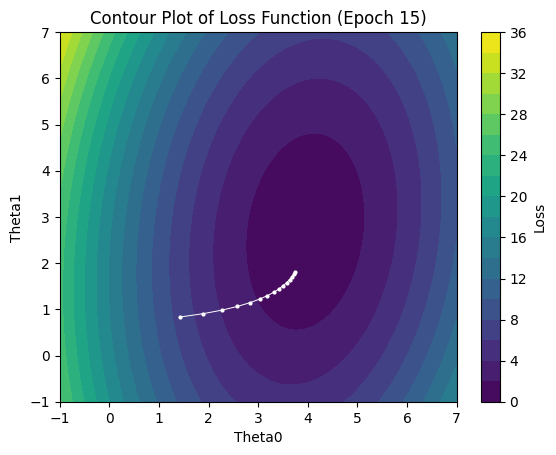

In [105]:
contour_plot_animation(theta_0_history_full, theta_1_history_full, x1_torch, y_torch, save_dir='animations', file='optimization_path_fbgd.gif')

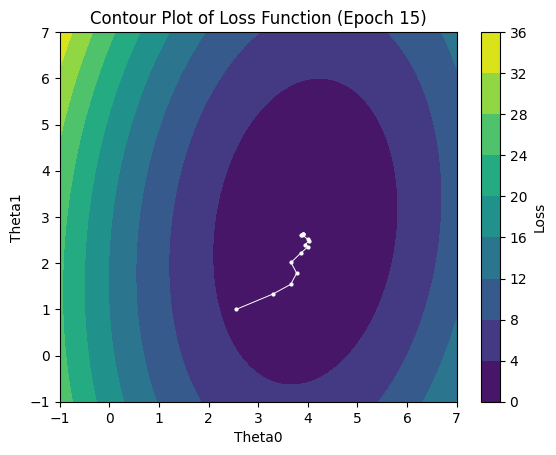

In [106]:
contour_plot_animation(theta_0_history_mini, theta_1_history_mini, x1_torch, y_torch, save_dir='animations', file='optimization_path_mbgd.gif',levels=10)

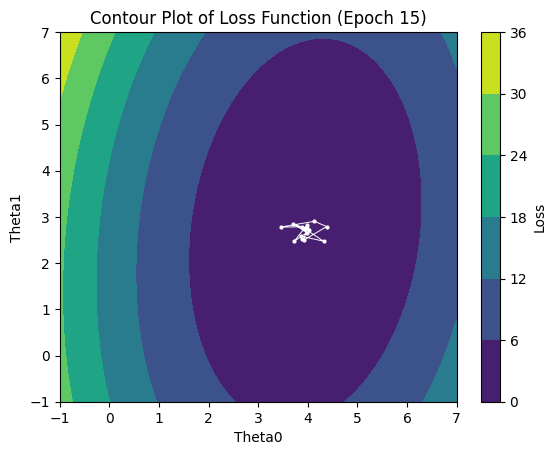

In [107]:
contour_plot_animation(theta_0_history_stoch, theta_1_history_stoch, x1_torch, y_torch, save_dir='animations', file='optimization_path_sgd.gif',levels=5)

In [108]:
import matplotlib.pyplot as plt

def plot_loss_vs_epochs(fb_history, mb_history, sgd_history):
    plt.plot(fb_history, label='Full-Batch GD')
    plt.plot(mb_history, label='Mini-Batch GD')
    plt.plot(sgd_history, label='Stochastic GD')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epochs for Different Methods')
    plt.legend()
    plt.show()

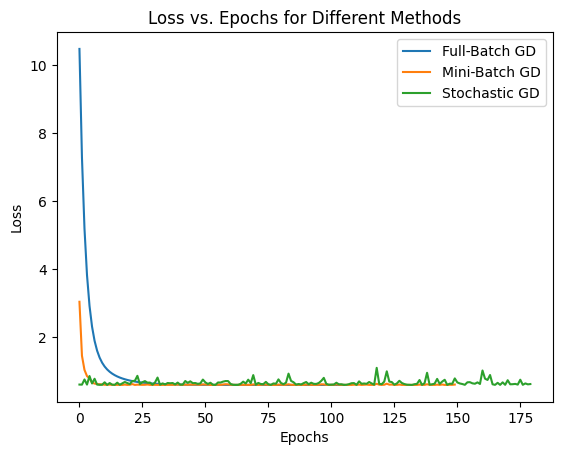

In [109]:
plot_loss_vs_epochs(loss_history_full, loss_history_mini, loss_history_stoch)

Why are the losses not converging?

A learning rate of 0.1 may be too high or too low. If it is too high, the optimizer may overshoot the minimum, causing the loss to oscillate or grow rather than converge. The model's starting weights and biases may be far from the best answer. Even though PyTorch initializes them at random, depending on the data and the task, the initial values may be poorly conditioned or not suitable, slowing convergence. During data generation, we use eps = np.random.randn(num_samples) to introduce Gaussian noise to the target y. Depending on the level of the noise, the model may have difficulty finding a solution that adequately matches the noisy data. Ipoch number might have been less. Epsilon value is too low for the dataset, if it would have been higher, it would have converged sooner.

### Explore the article here on gradient descent with momentum. Implement gradient descent with momentum for the dataset. Visualize the convergence process for 15 steps. Compare the average number of steps taken with gradient descent (for variants full batch and stochastic) with momentum to that of vanilla gradient descent to converge to an ϵ-neighborhood for both dataset. Choose ϵ=0.001. Write down your observations. Show the contour plots for different epochs for momentum implementation. Specifically, show all the vectors: gradient, current value of theta, momentum, etc.

In [110]:
def gd_with_momentum(x, y, lr=0.1, beta=0.9, epochs=150, epsilon=0.001, batch_size=None):
    torch.manual_seed(42)

    # Initialize the model (linear regression with 1 feature)
    model = nn.Linear(1, 1, bias=True)

    # Loss function
    criterion = nn.MSELoss()

    # Optimizer with momentum
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=beta)

    # History for visualization
    theta_0_history = []
    theta_1_history = []
    loss_history = []
    momentum_history = []
    gradients = []

    # Full-batch or mini-batch approach
    for epoch in range(epochs):
        if batch_size is None:  # Full-batch gradient descent
            x_batch = x
            y_batch = y

            # Forward pass
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Capture gradient before step
            grad_theta_0 = model.bias.grad.item()
            grad_theta_1 = model.weight.grad.item()

            # Update model parameters using momentum
            optimizer.step()

            # Record loss, parameters, and gradient after each epoch
            loss_history.append(loss.item())
            theta_0_history.append(model.bias.item())
            theta_1_history.append(model.weight.item())
            gradients.append([grad_theta_0, grad_theta_1])

            # Track momentum (velocity update)
            momentum_0 = optimizer.state[model.bias]['momentum_buffer'].item() if 'momentum_buffer' in optimizer.state[model.bias] else 0
            momentum_1 = optimizer.state[model.weight]['momentum_buffer'].item() if 'momentum_buffer' in optimizer.state[model.weight] else 0
            momentum_history.append([momentum_0, momentum_1])

            # Check for convergence
            if loss.item() < epsilon:
                break

        else:  # Mini-batch gradient descent
            dataloader = DataLoader(list(zip(x, y)), batch_size=batch_size, shuffle=True)
            for x_batch, y_batch in dataloader:
                # Forward pass
                y_pred = model(x_batch)
                loss = criterion(y_pred, y_batch)

                # Backward pass (compute gradients)
                optimizer.zero_grad()
                loss.backward()

                # Capture gradient before step
                grad_theta_0 = model.bias.grad.item()
                grad_theta_1 = model.weight.grad.item()

                # Update parameters
                optimizer.step()

            # After processing all mini-batches, compute loss on the full dataset
            with torch.no_grad():
                y_pred_full = model(x)  # Full dataset prediction
                full_loss = criterion(y_pred_full, y)
                loss_history.append(full_loss.item())

                # Record the current parameters (theta_0 and theta_1)
                theta_0_history.append(model.bias.item())
                theta_1_history.append(model.weight.item())
                gradients.append([grad_theta_0, grad_theta_1])

                # Track momentum (velocity update)
                momentum_0 = optimizer.state[model.bias]['momentum_buffer'].item() if 'momentum_buffer' in optimizer.state[model.bias] else 0
                momentum_1 = optimizer.state[model.weight]['momentum_buffer'].item() if 'momentum_buffer' in optimizer.state[model.weight] else 0
                momentum_history.append([momentum_0, momentum_1])

                # Check for convergence
                if full_loss.item() < epsilon:
                    break

    return theta_0_history, theta_1_history, momentum_history, gradients, loss_history


In [111]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import matplotlib.patches as mpatches

def plot_contour_with_vectors(theta_0_history, theta_1_history, gradient_history, momentum_history, x, y, model, num_epochs=15, save_dir='contour_plots'):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Convert inputs to numpy for contour plotting
    x_np = x.numpy().flatten()
    y_np = y.numpy().flatten()

    # Generate grid points for theta_0 and theta_1
    t0 = np.linspace(-2, 7, 100)
    t1 = np.linspace(-2, 7, 100)
    T0, T1 = np.meshgrid(t0, t1)

    Z = np.zeros_like(T0)

    # Compute loss over the grid
    criterion = torch.nn.MSELoss()
    for i in range(len(t0)):
        for j in range(len(t1)):
            theta_0 = T0[i, j]
            theta_1 = T1[i, j]
            y_pred = theta_1 * torch.tensor(x_np, dtype=torch.float32) + theta_0
            loss = criterion(y_pred, torch.tensor(y_np, dtype=torch.float32))
            Z[i, j] = loss.item()

    # Plot trajectories and vectors for each epoch
    for epoch in range(min(num_epochs, len(theta_0_history))):
        # Create a figure and axis
        fig, ax = plt.subplots(figsize=(10, 8))

        # Create contour plot
        contour = ax.contourf(T0, T1, Z, levels=20, cmap='viridis')
        fig.colorbar(contour, label='Loss')

        # Current theta values
        theta_0 = theta_0_history[epoch]
        theta_1 = theta_1_history[epoch]

        # Current gradients and momentum
        gradient = gradient_history[epoch]
        momentum = momentum_history[epoch]

        ax.quiver(0, 0, theta_0, theta_1, color='black', angles='xy', scale_units='xy', scale=1, width=0.004, label='Theta')

        # Plot current point
        ax.plot(theta_0, theta_1, 'o', color='black')  # Current theta value

         # Normalize vectors to ignore magnitude (consider only direction)
        grad_0, grad_1 = gradient / np.linalg.norm(gradient) if np.linalg.norm(gradient) != 0 else gradient
        mom_0, mom_1 = momentum / np.linalg.norm(momentum) if np.linalg.norm(momentum) != 0 else momentum

        # Plot gradient

        ax.quiver(theta_0, theta_1, -grad_0, -grad_1, color='gold', angles='xy', scale_units='xy', scale=1, width=0.002)

        # Plot momentum

        ax.quiver(theta_0, theta_1, mom_0, mom_1, color='red', angles='xy', scale_units='xy', scale=1, width=0.002)

        # Add labels and title
        ax.set_xlabel('Theta 0')
        ax.set_ylabel('Theta 1')
        ax.set_title(f'Contour Plot with Gradients and Momentum Vectors (Epoch {epoch + 1})')
        legend_handles = [
            mpatches.Patch(color='gold', label='Gradient Vector'),
            mpatches.Patch(color='red', label='Momentum Vector'),
            mpatches.Patch(color='black', label='Theta Vector')
        ]

        ax.legend(handles=legend_handles)


        # plt.legend()
        # Save the plot
        plt.savefig(os.path.join(save_dir, f'contour_epoch_{epoch + 1}.png'))
        plt.show()



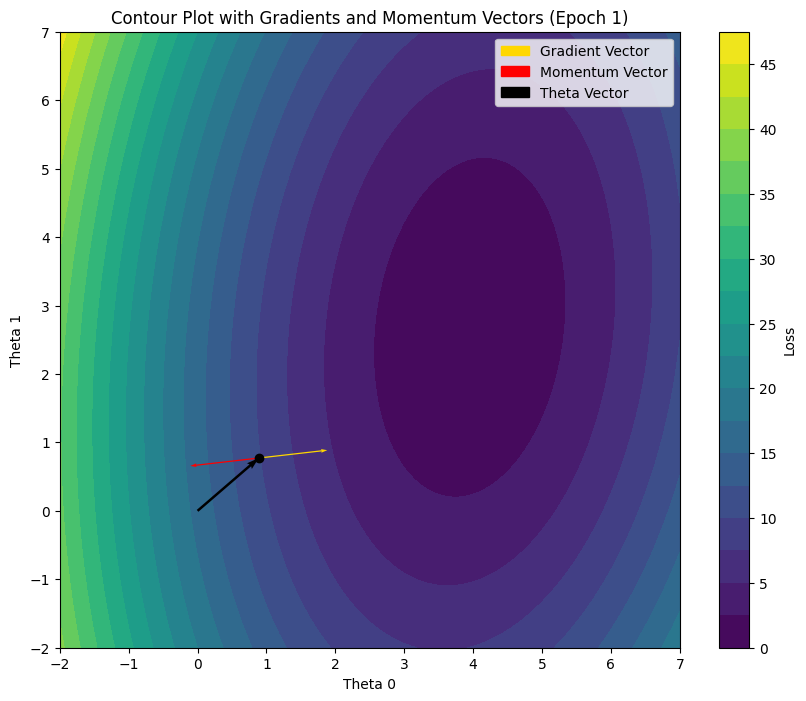

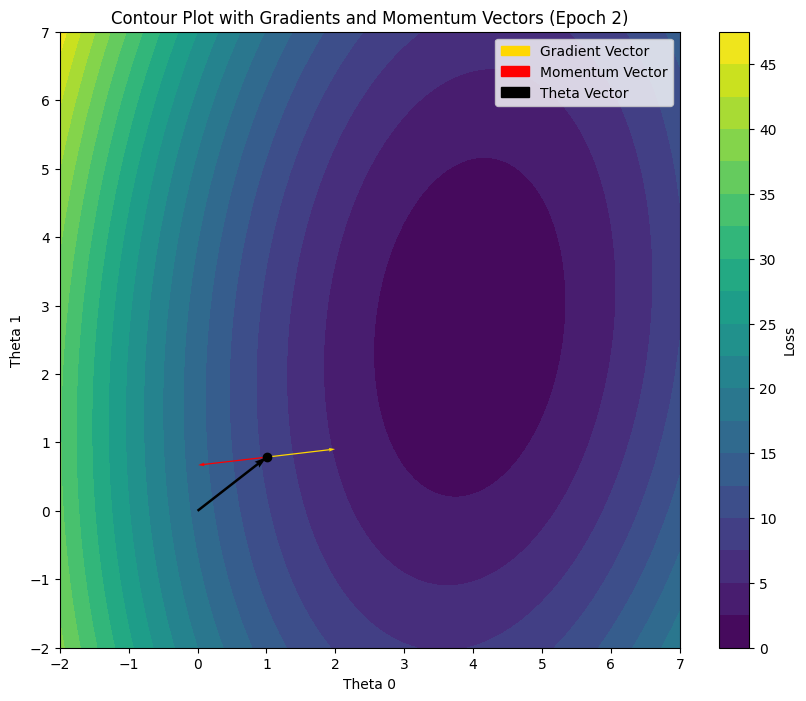

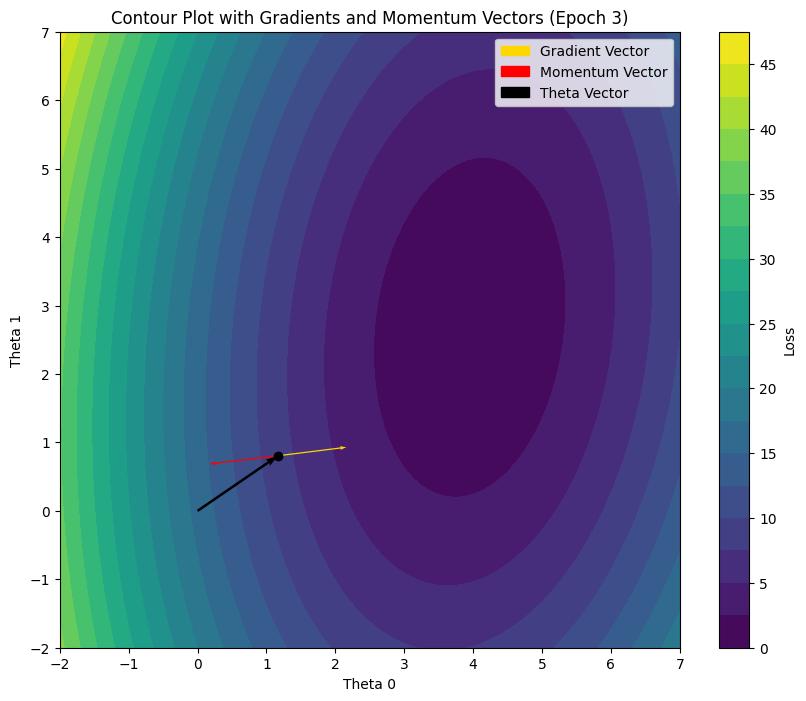

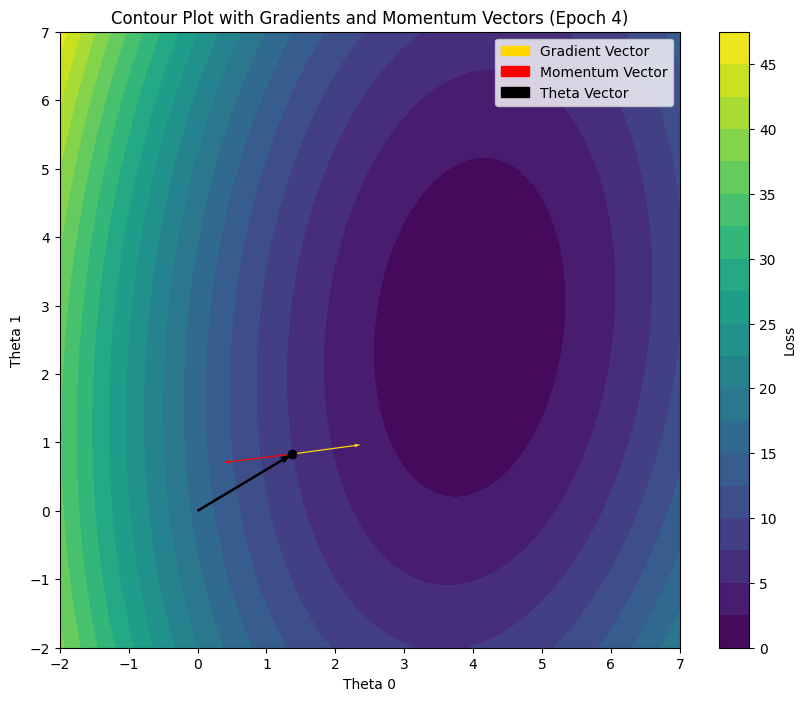

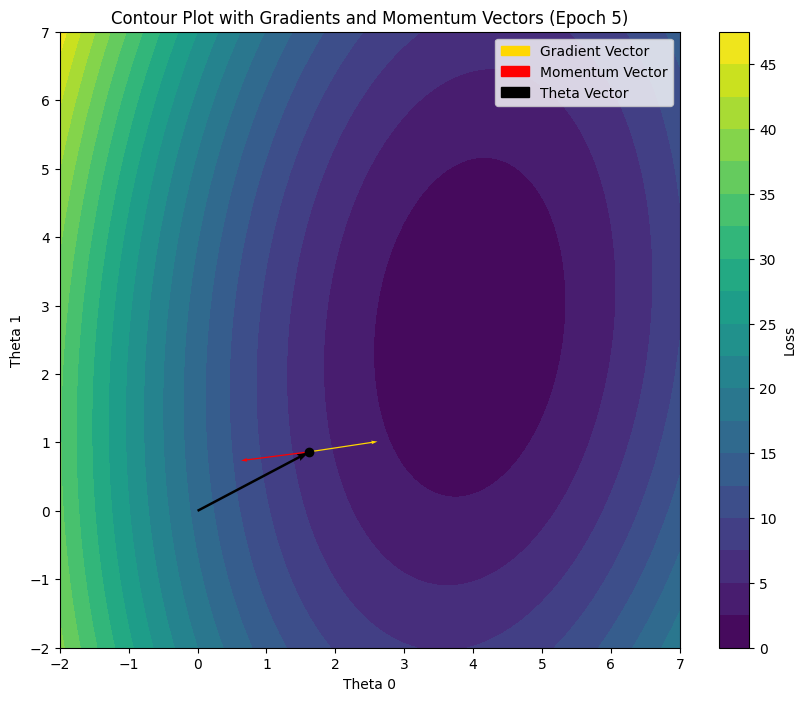

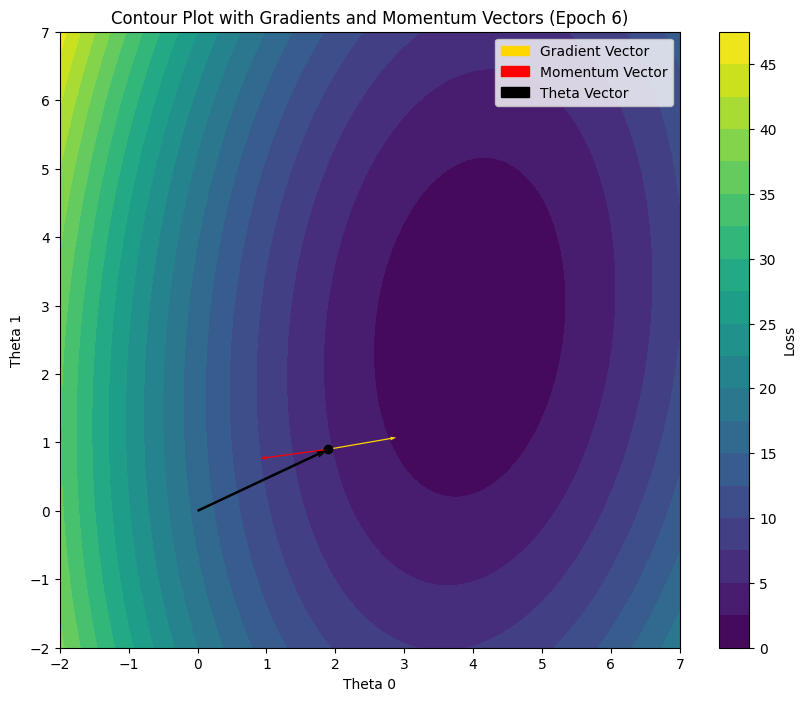

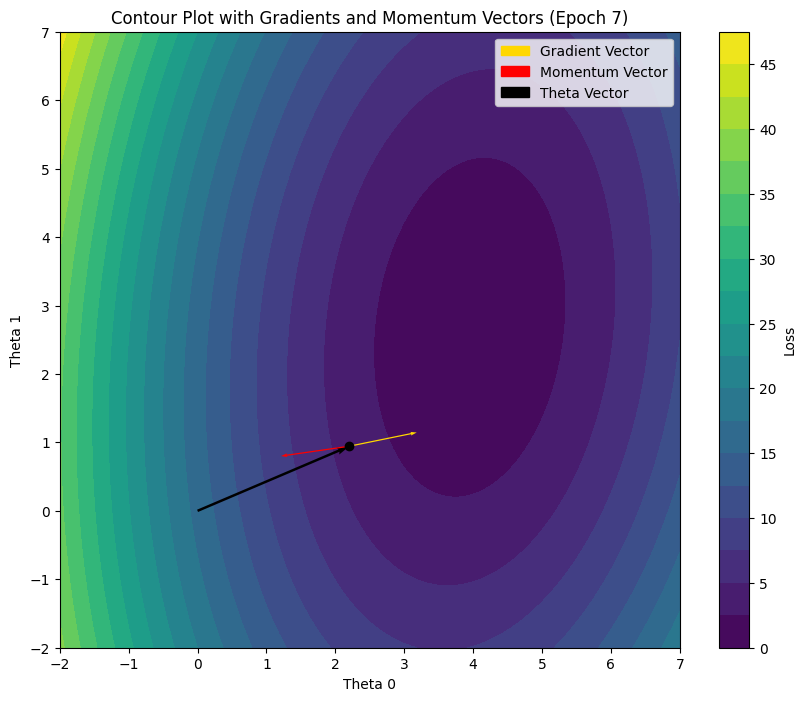

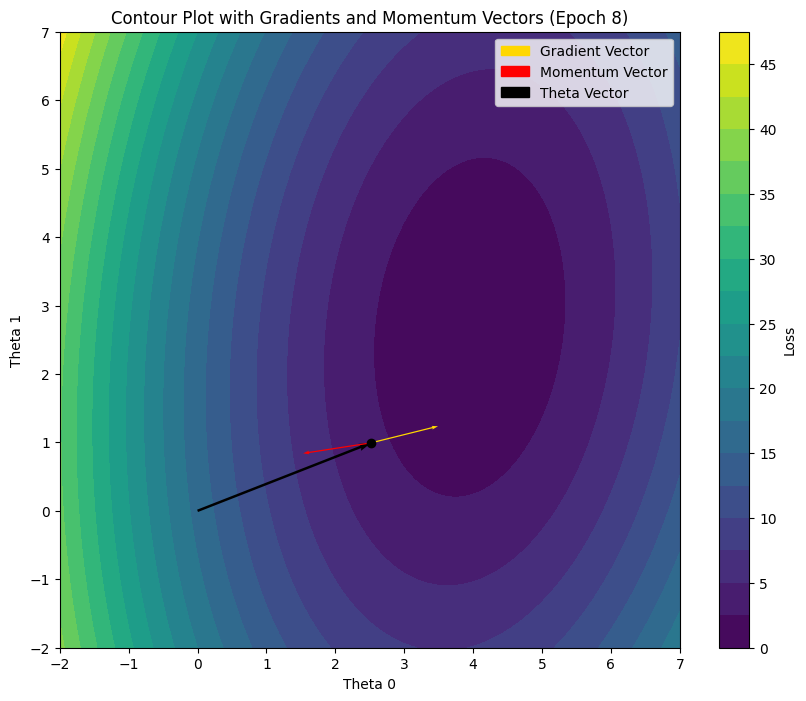

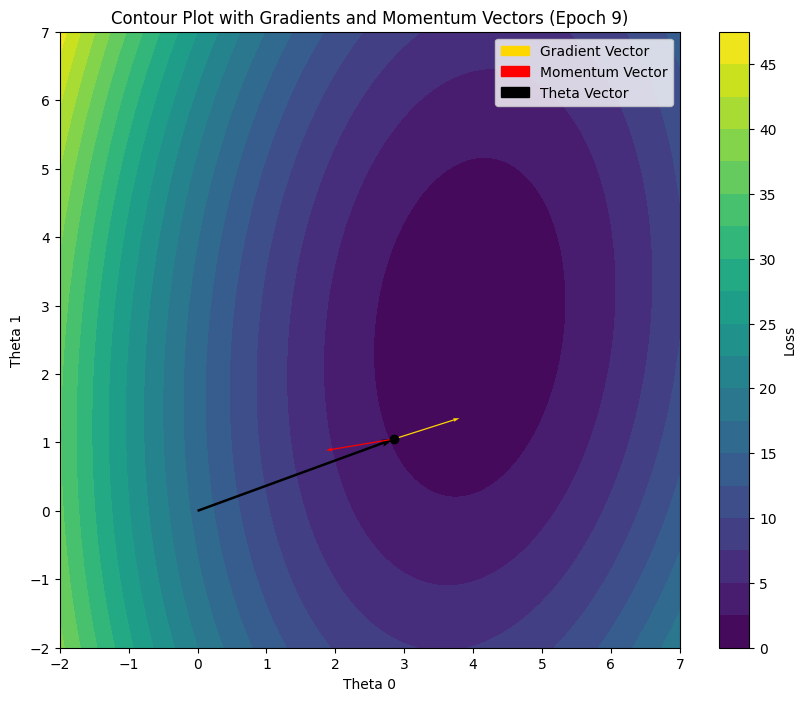

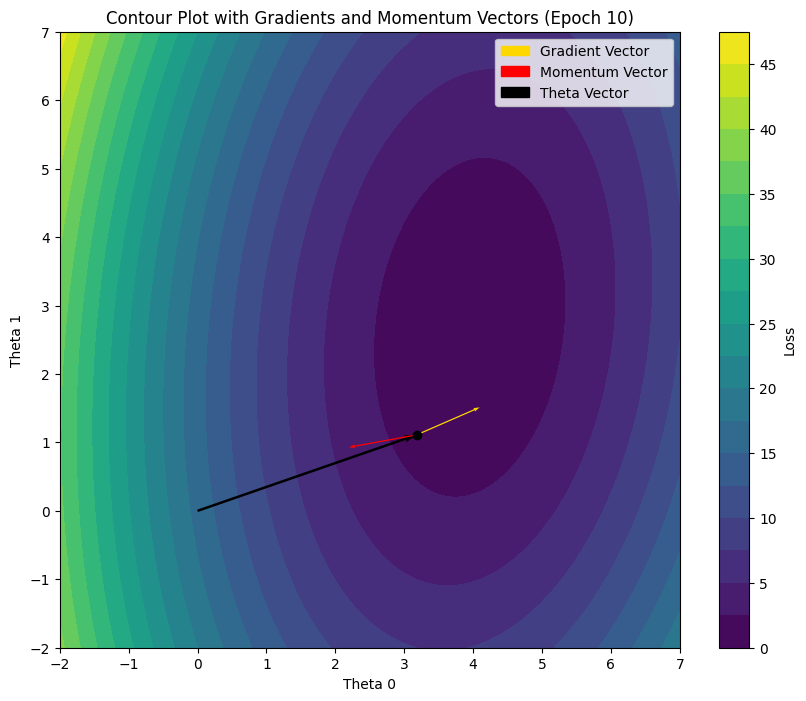

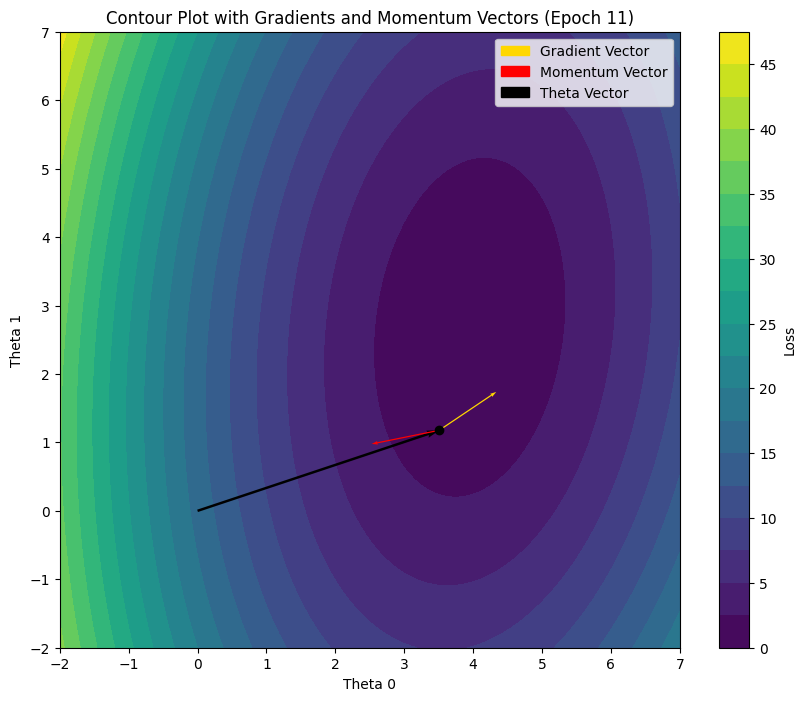

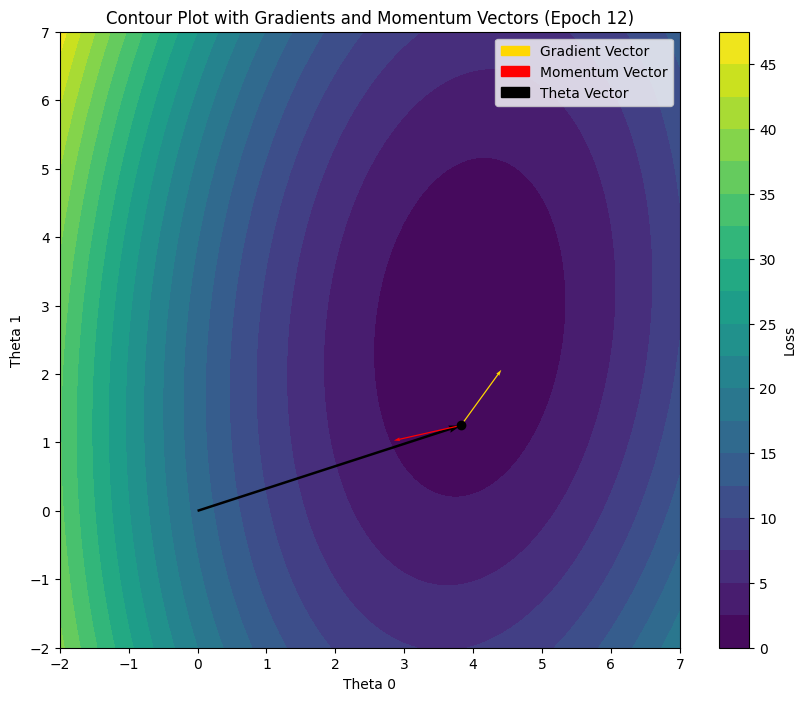

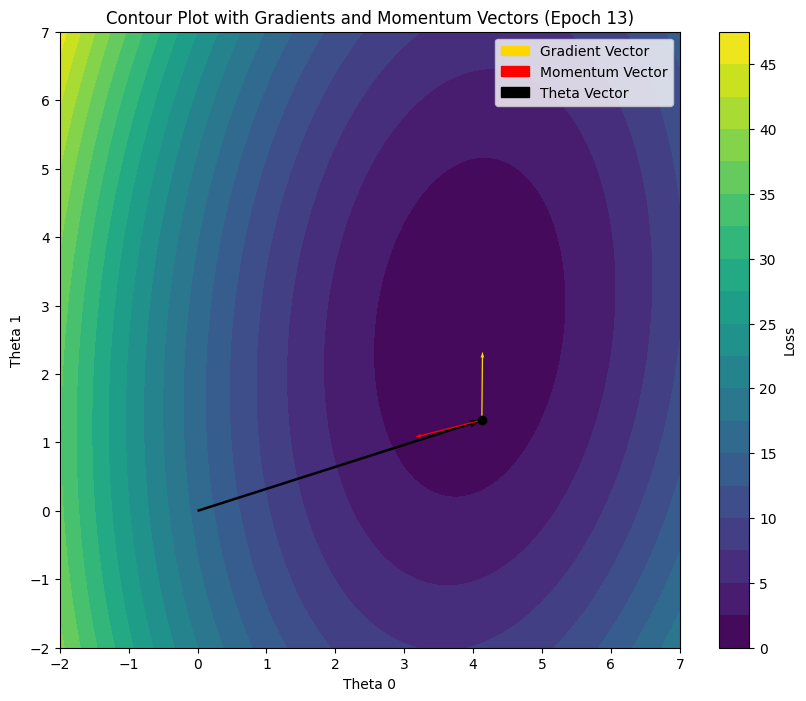

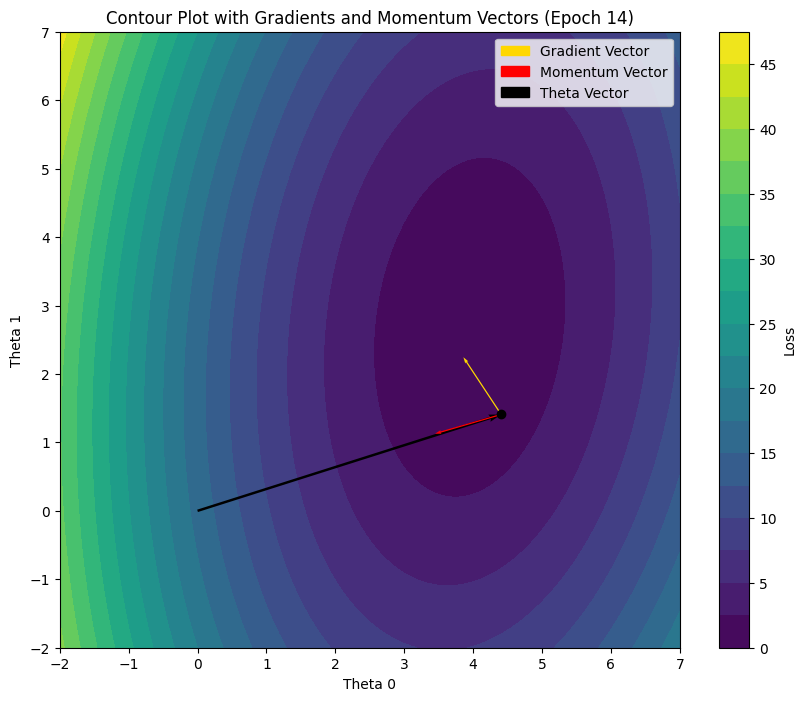

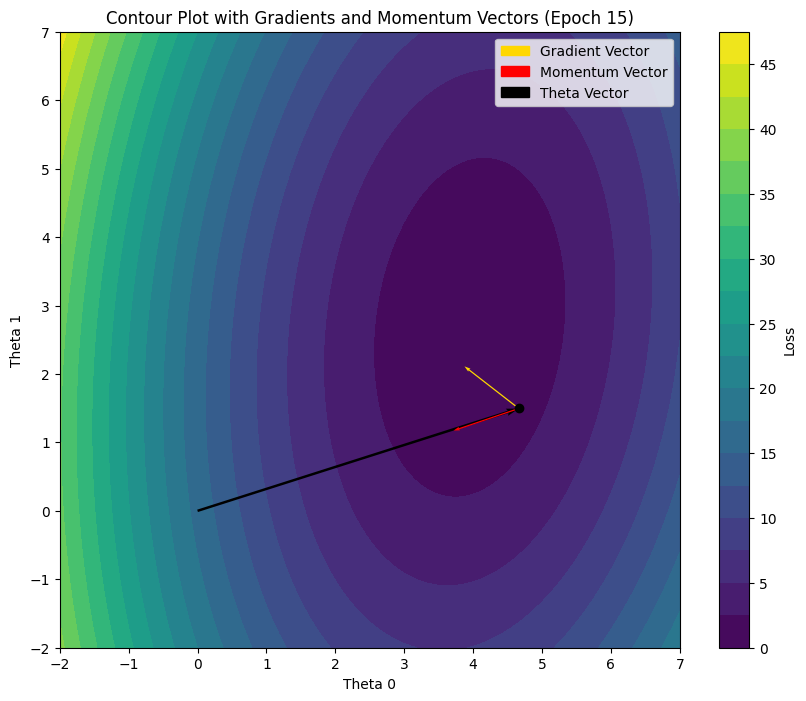

In [112]:
#For Full batch gradient descent with momentum
theta_0_history_momentum_full, theta_1_history_momentum_full, momentum_history_full, gradient_history_momentum_full, loss_history_momentum_full = gd_with_momentum(x1_torch, y_torch, lr=0.01, beta=0.95, epochs=150, epsilon=0.001, batch_size=None)
plot_contour_with_vectors(theta_0_history_momentum_full, theta_1_history_momentum_full, gradient_history_momentum_full, momentum_history_full, x1_torch, y_torch, model, num_epochs=15,  save_dir='contour_plots_full')


In [113]:
print("The losses over 150 epochs for full batch gradient descent with momentum:")
for i in range(len(loss_history_momentum_full)):
  print(f"loss at epoch{i+1} is", loss_history_momentum_full[i])


The losses over 150 epochs for full batch gradient descent with momentum:
loss at epoch1 is 10.482534408569336
loss at epoch2 is 10.131263732910156
loss at epoch3 is 9.472600936889648
loss at epoch4 is 8.570112228393555
loss at epoch5 is 7.500191688537598
loss at epoch6 is 6.344902038574219
loss at epoch7 is 5.185067176818848
loss at epoch8 is 4.094141960144043
loss at epoch9 is 3.1332714557647705
loss at epoch10 is 2.347792148590088
loss at epoch11 is 1.7653086185455322
loss at epoch12 is 1.395346999168396
loss at epoch13 is 1.2304507493972778
loss at epoch14 is 1.248490571975708
loss at epoch15 is 1.4158895015716553
loss at epoch16 is 1.691420316696167
loss at epoch17 is 2.0302181243896484
loss at epoch18 is 2.3876755237579346
loss at epoch19 is 2.7229270935058594
loss at epoch20 is 3.001682996749878
loss at epoch21 is 3.198270320892334
loss at epoch22 is 3.2967758178710938
loss at epoch23 is 3.2913169860839844
loss at epoch24 is 3.1854805946350098
loss at epoch25 is 2.99107313156127

In [114]:
# losses for full batch vanilla gradient descent for lr = 0.01
theta_0_history_full2, theta_1_history_full2, loss_history_full2 = full_batch_gd(x1_torch, y_torch, lr = 0.01, epochs = 650)

for i in range(len(loss_history_full2)):
  print(f"loss at epoch{i+1} is", loss_history_full2[i])

Current Parameters:
tensor([-0.2343], grad_fn=<ViewBackward0>)
tensor([0.9186], grad_fn=<ViewBackward0>)


loss at epoch1 is 10.978372573852539
loss at epoch2 is 10.653478622436523
loss at epoch3 is 10.340482711791992
loss at epoch4 is 10.038919448852539
loss at epoch5 is 9.748342514038086
loss at epoch6 is 9.468328475952148
loss at epoch7 is 9.198467254638672
loss at epoch8 is 8.93836498260498
loss at epoch9 is 8.687644958496094
loss at epoch10 is 8.445943832397461
loss at epoch11 is 8.212911605834961
loss at epoch12 is 7.98821496963501
loss at epoch13 is 7.771531581878662
loss at epoch14 is 7.56255578994751
loss at epoch15 is 7.360986232757568
loss at epoch16 is 7.166542053222656
loss at epoch17 is 6.978947639465332
loss at epoch18 is 6.797940731048584
loss at epoch19 is 6.623269081115723
loss at epoch20 is 6.454690456390381
loss at epoch21 is 6.2919721603393555
loss at epoch22 is 6.134890556335449
loss at epoch23 is 5.983229637145996
loss at epoch24 is 5.836784839630127
loss at epoc

In my case, losses by both gradient descent variants didnt converge to the given value in the question.

For full batch gradint descent using momentum, the loss value at 150 epoch is less than the loss value at same epoch for full batch vanilla gradient descent. This means that full batch gradint descent using momentum converges the loss faster than full batch vanilla gradient descent. At around 145th epoch the loss is plateauing for full batch gradient descent with momentum. This loss value was reached at around 645th epoch by vanilla gradient descent.

This says that full batch gradient descent using momentum converges faster than full batch vanilla gradient descent.

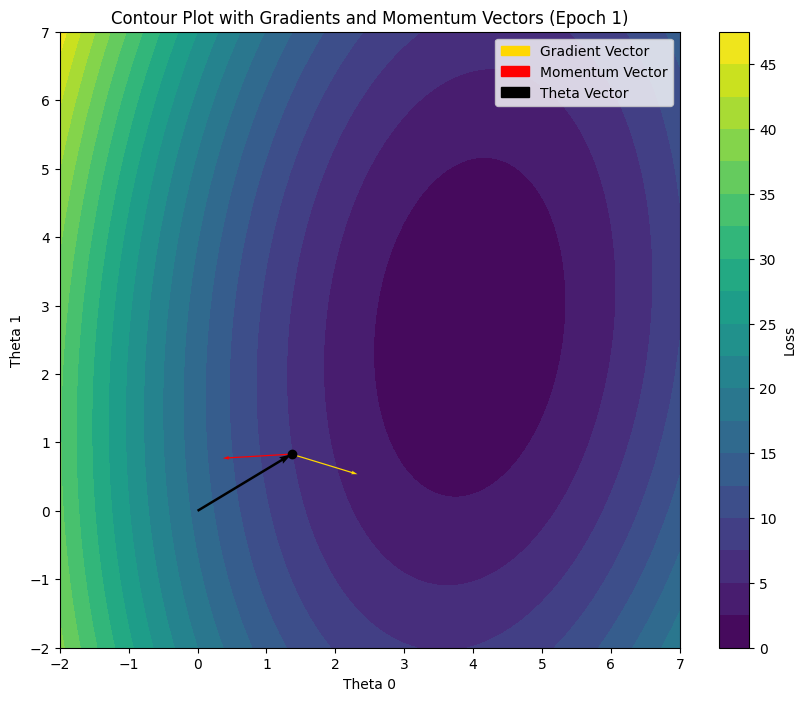

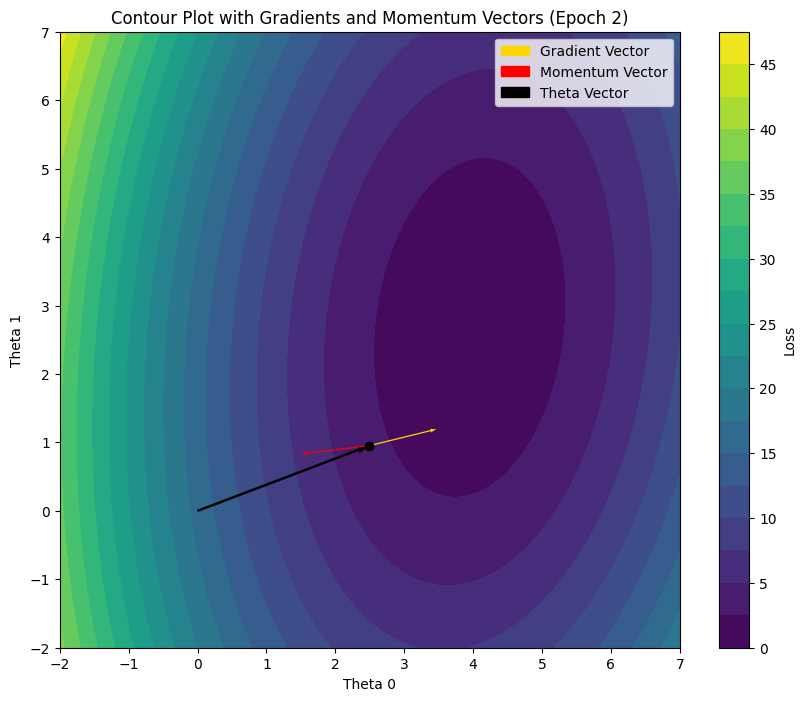

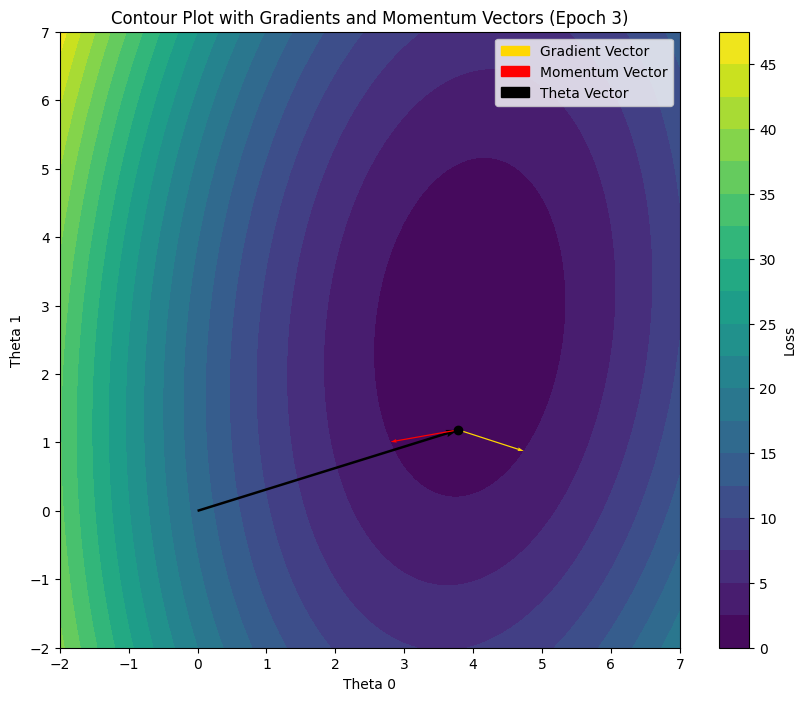

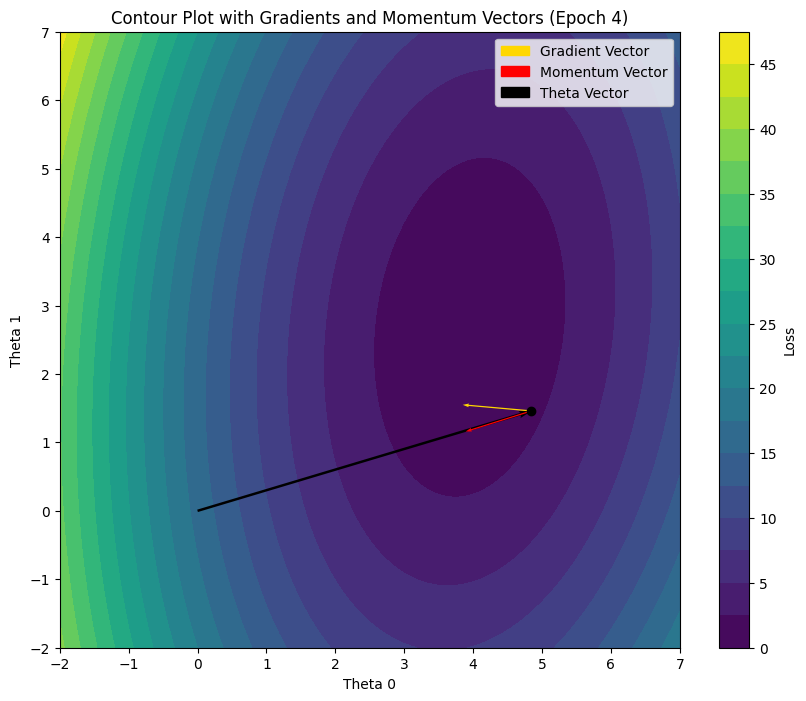

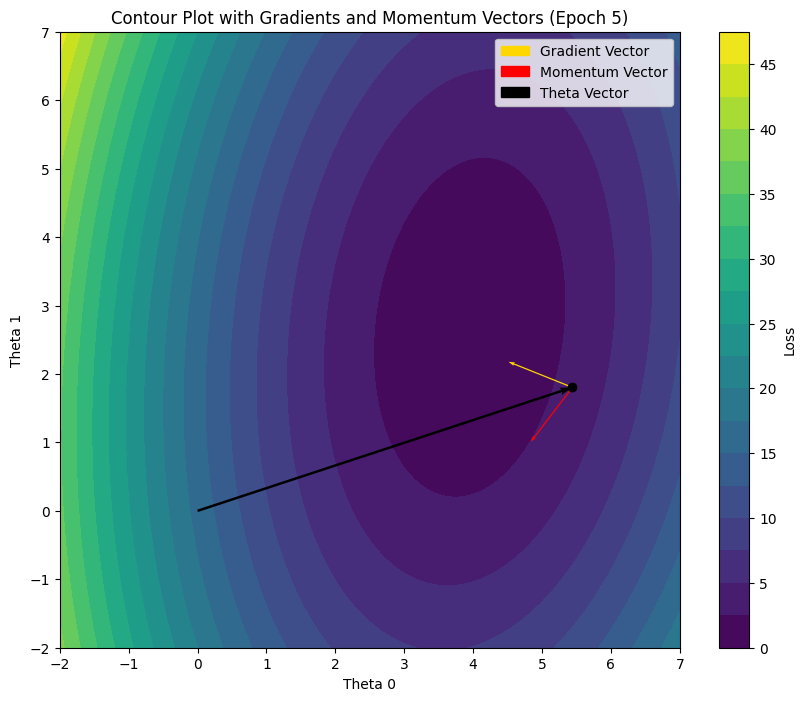

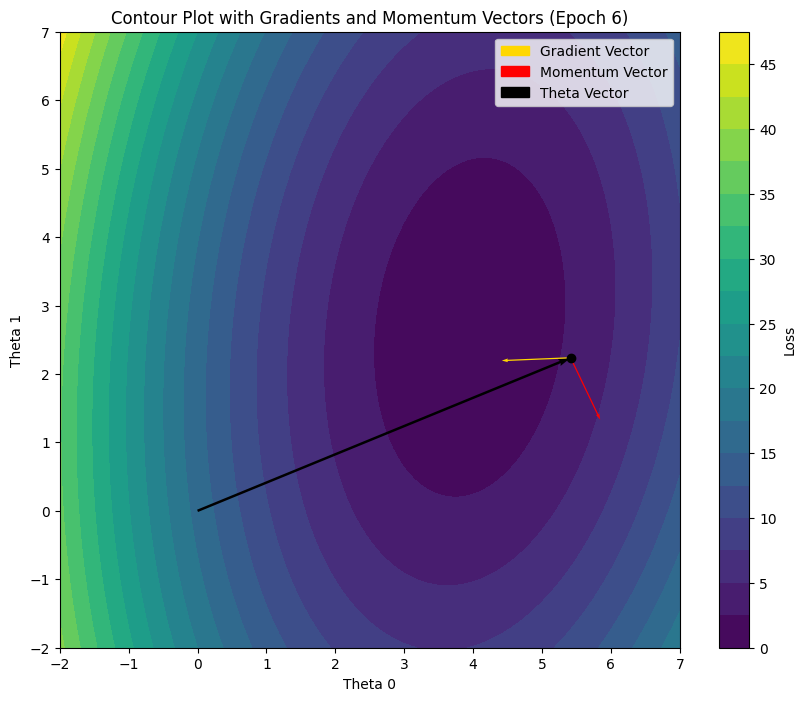

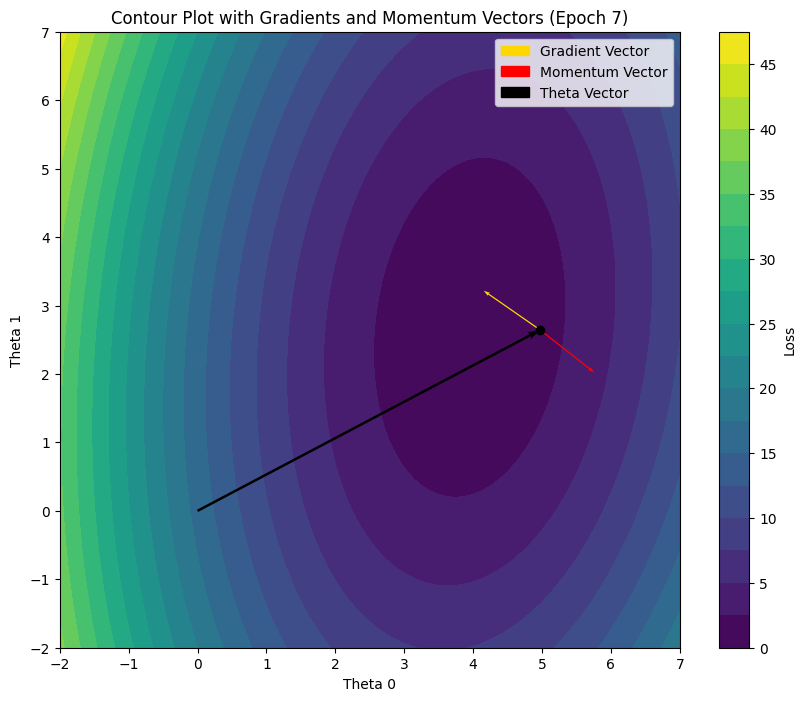

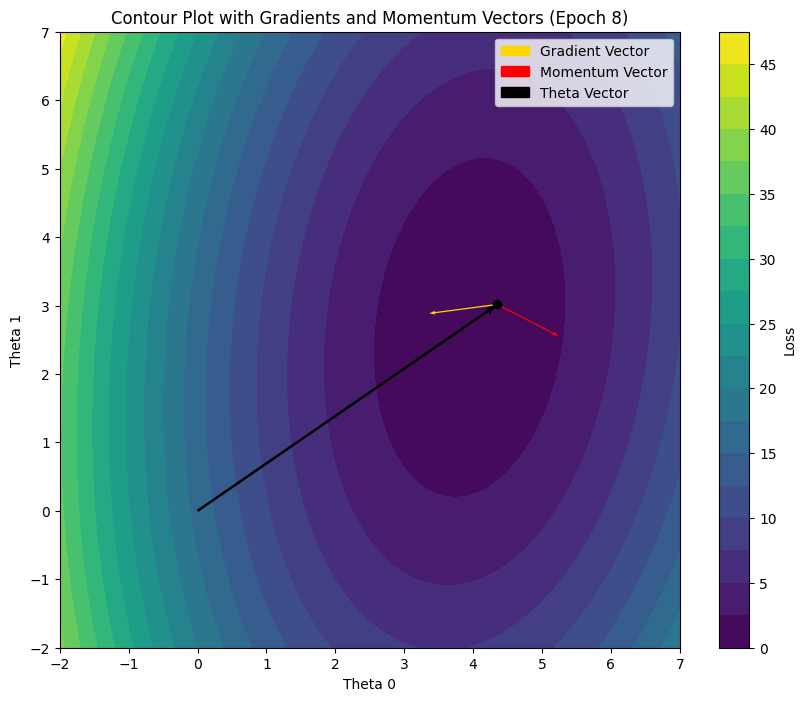

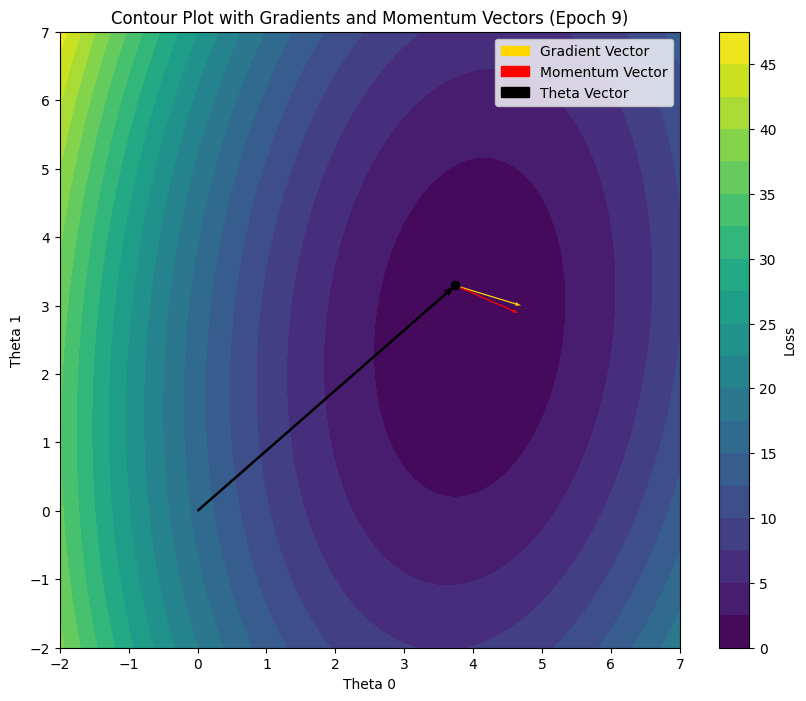

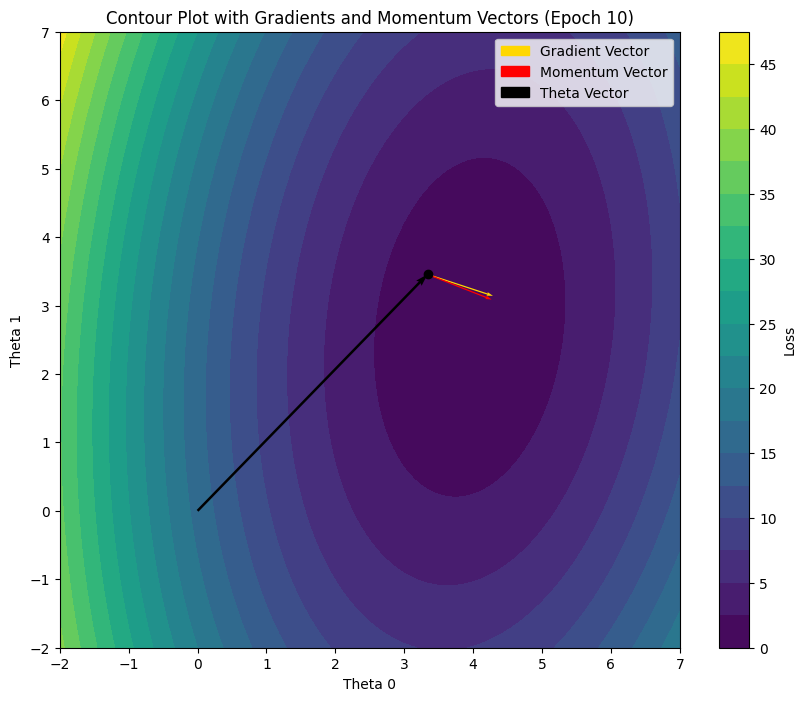

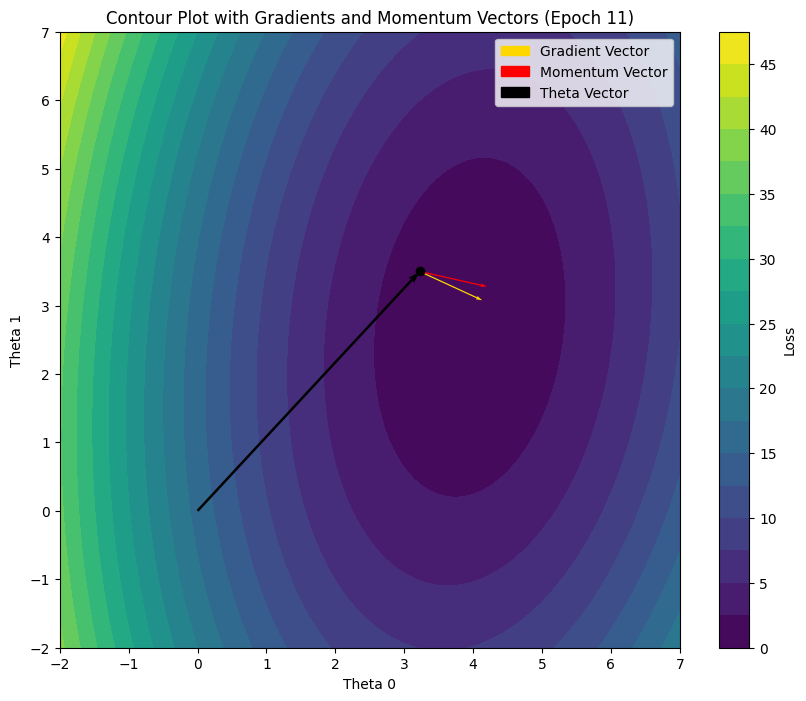

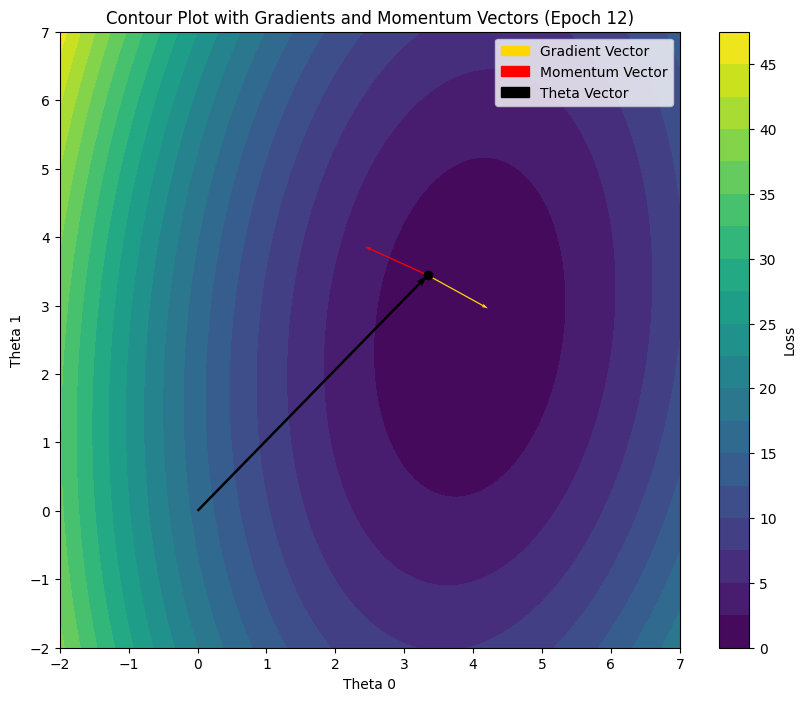

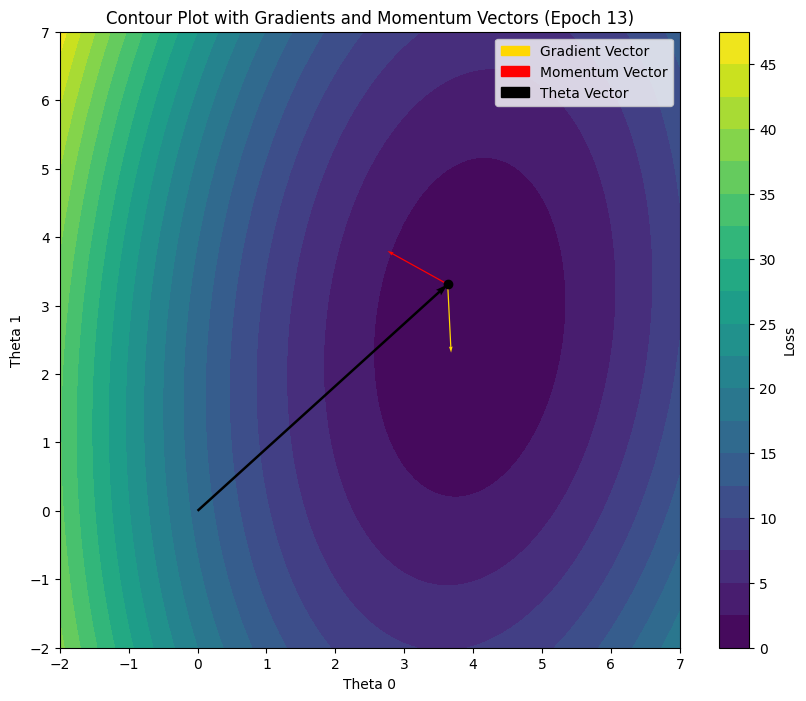

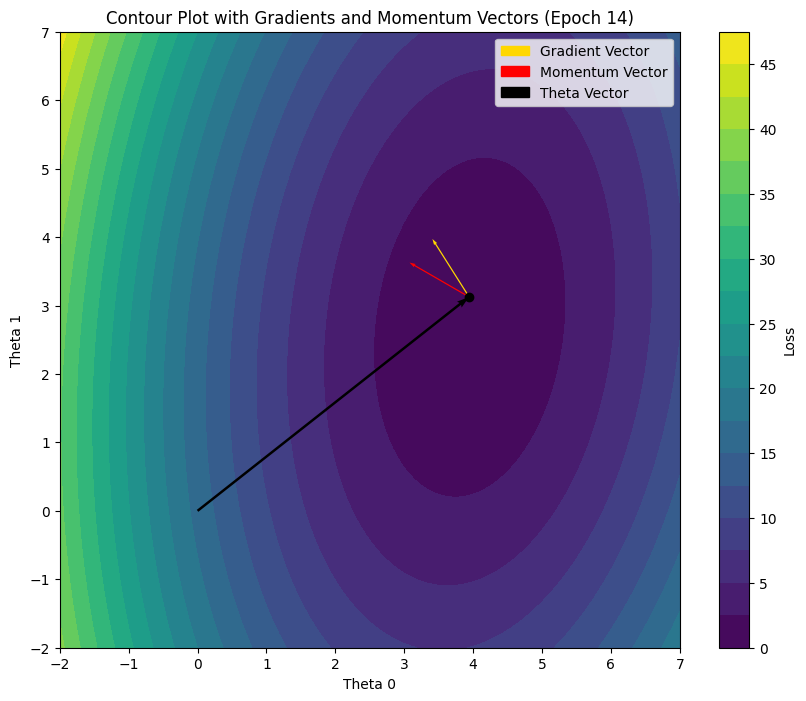

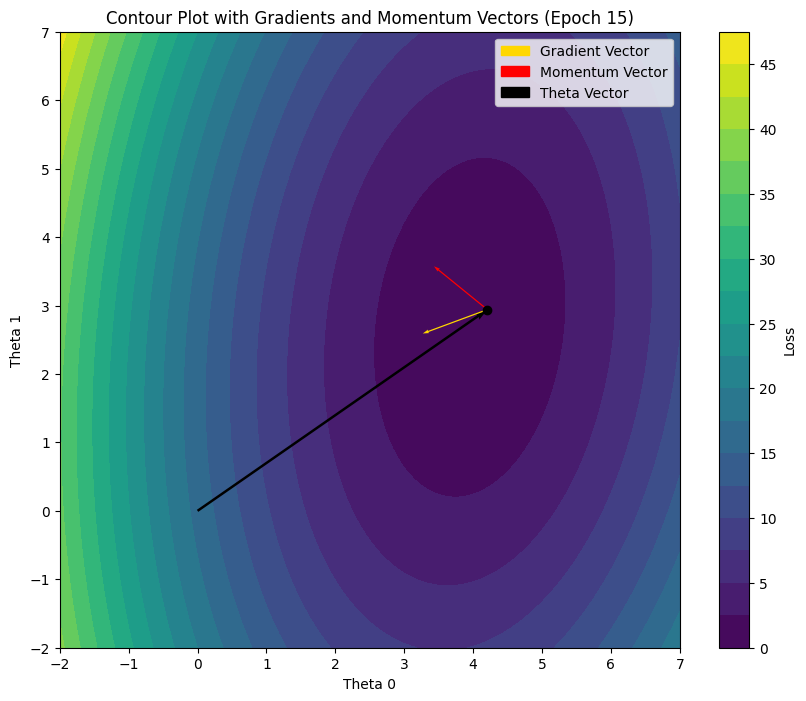

In [115]:
#For mini batch gradient descent with momentum
theta_0_history_momentum_mini, theta_1_history_momentum_mini, momentum_history_mini, gradient_history_momentum_mini, loss_history_momentum_mini = gd_with_momentum(x1_torch, y_torch, lr=0.01, beta=0.95, epochs=150, epsilon=0.001, batch_size=12)
plot_contour_with_vectors(theta_0_history_momentum_mini, theta_1_history_momentum_mini, gradient_history_momentum_mini, momentum_history_mini, x1_torch, y_torch, model, num_epochs=15,save_dir='contour_plots_mini')

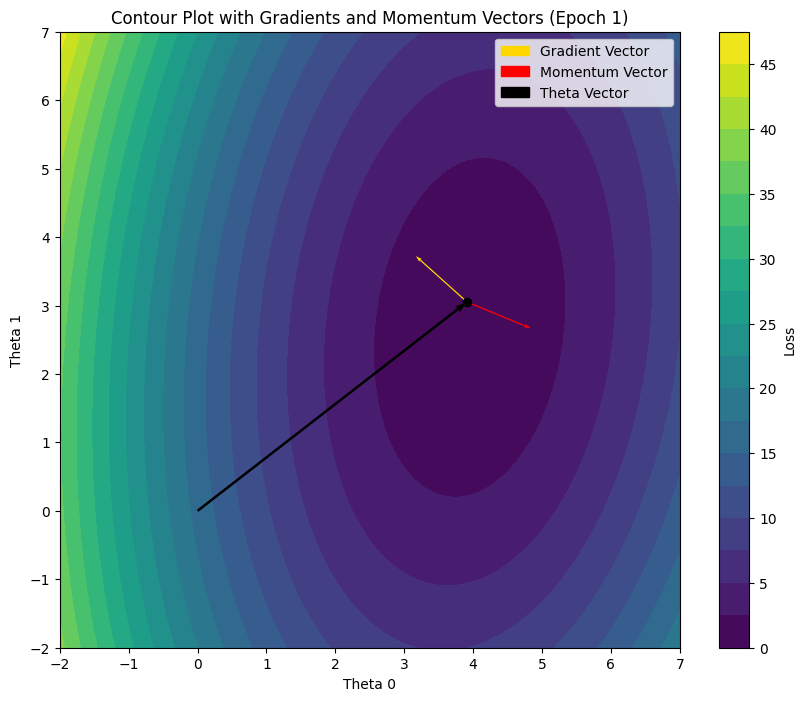

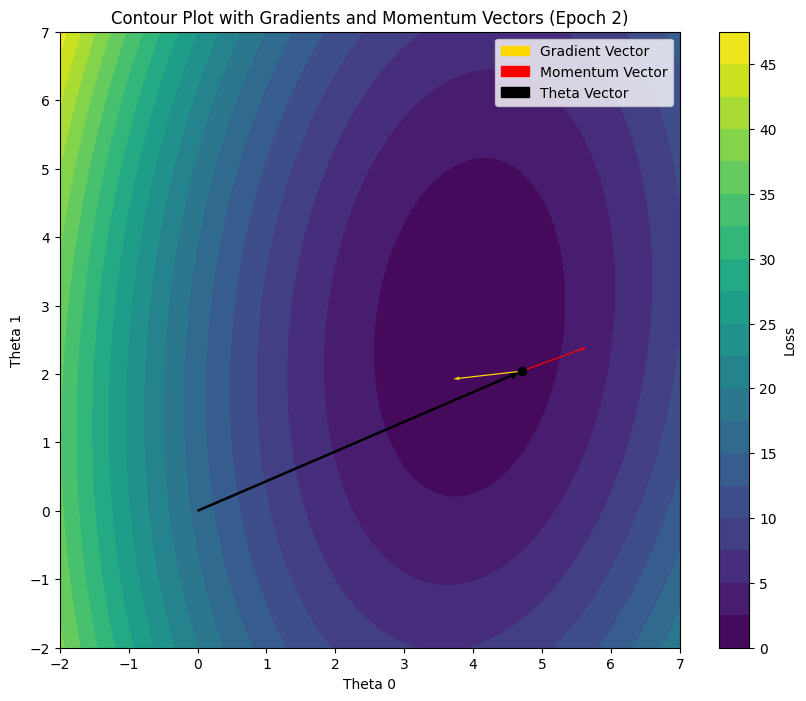

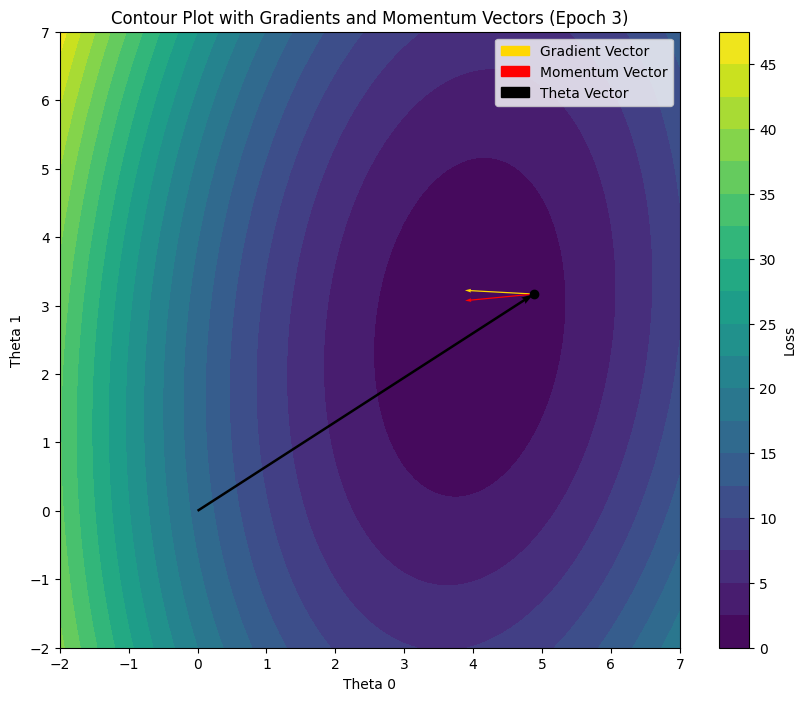

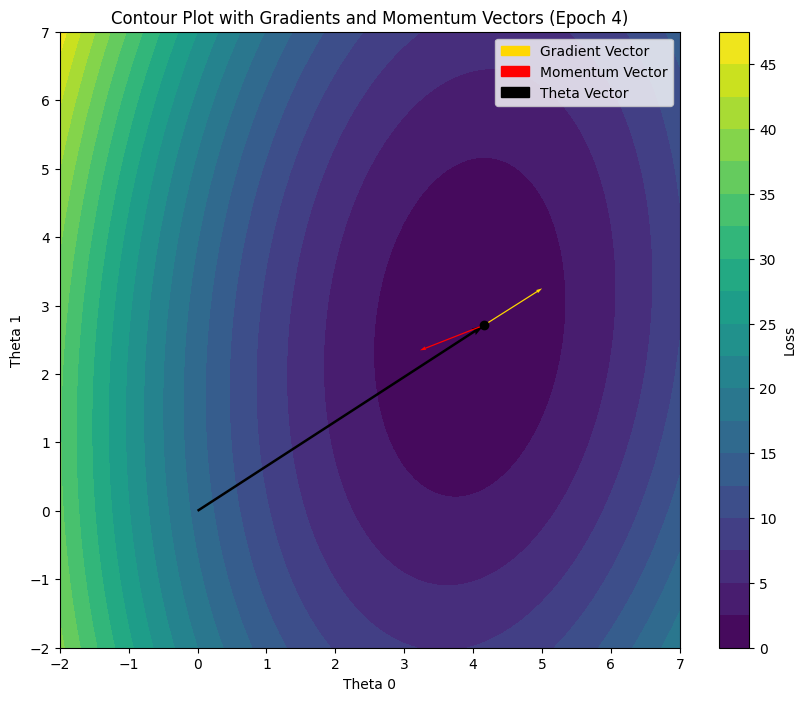

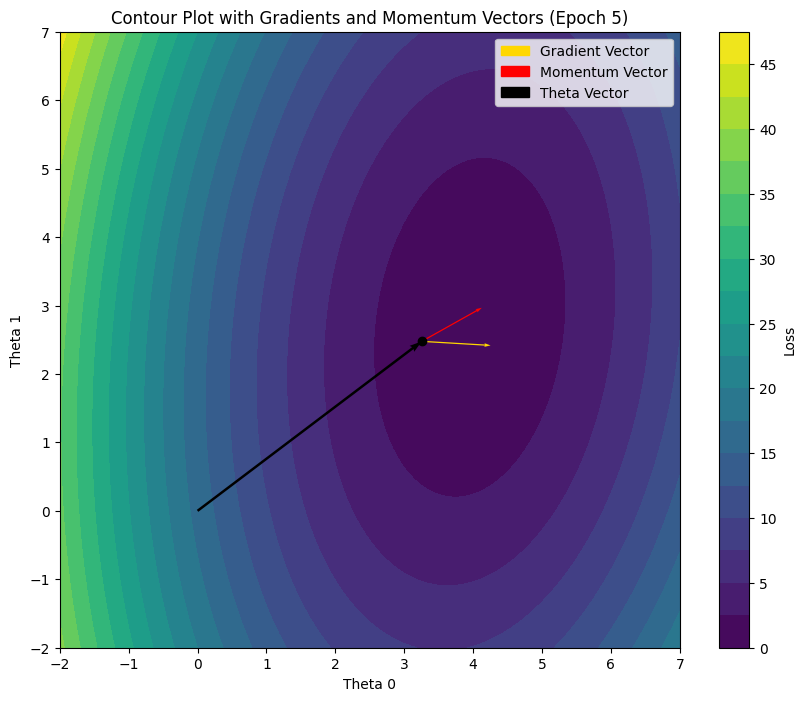

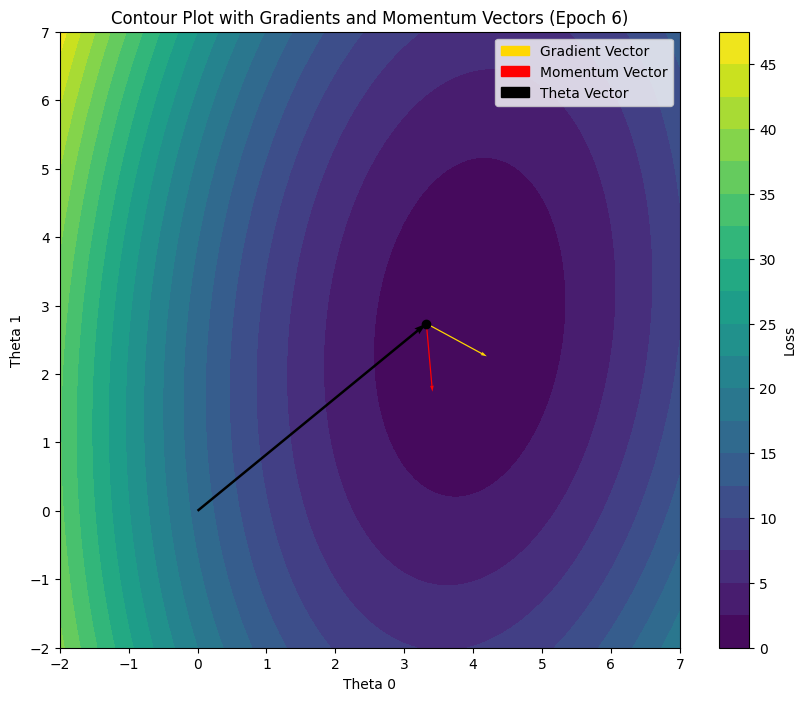

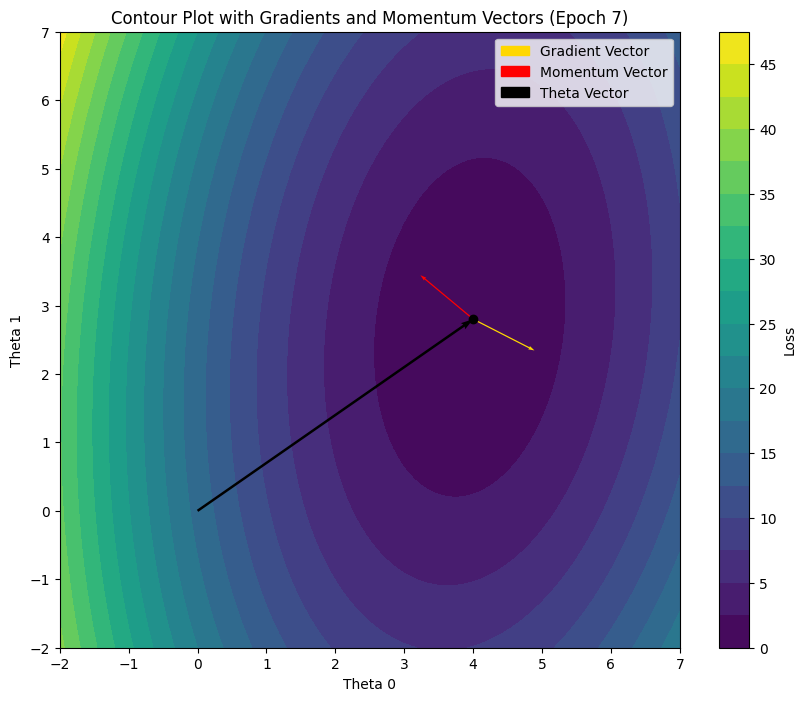

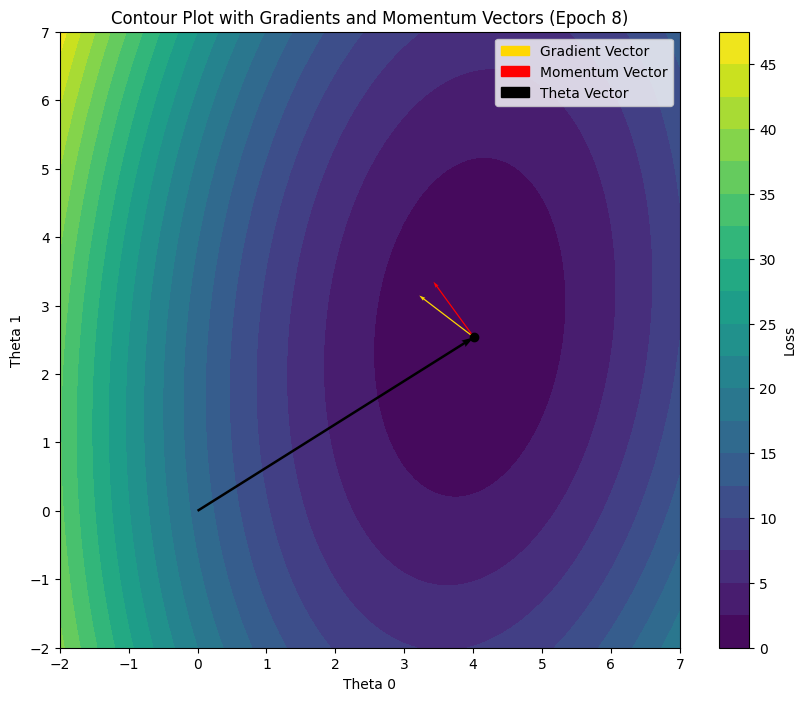

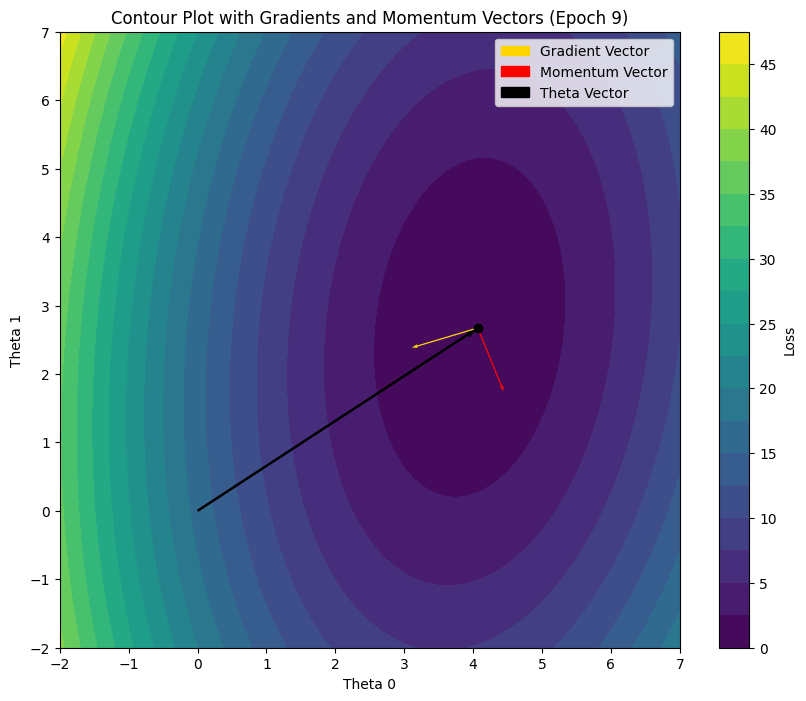

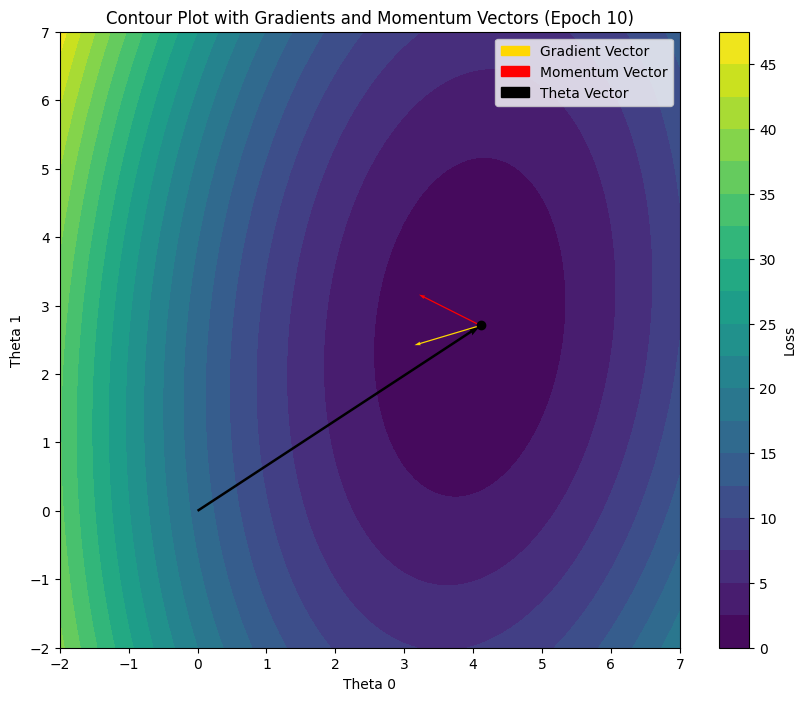

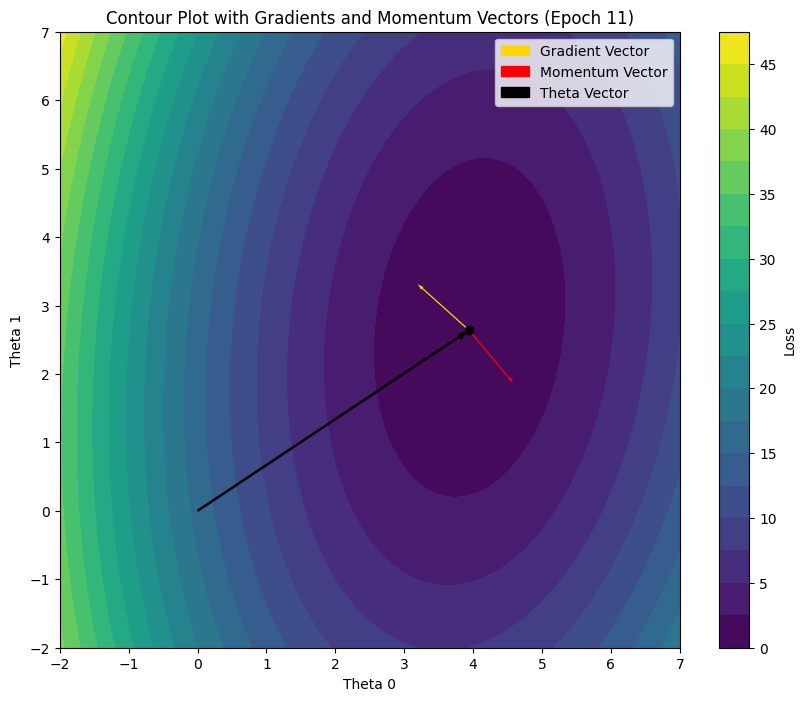

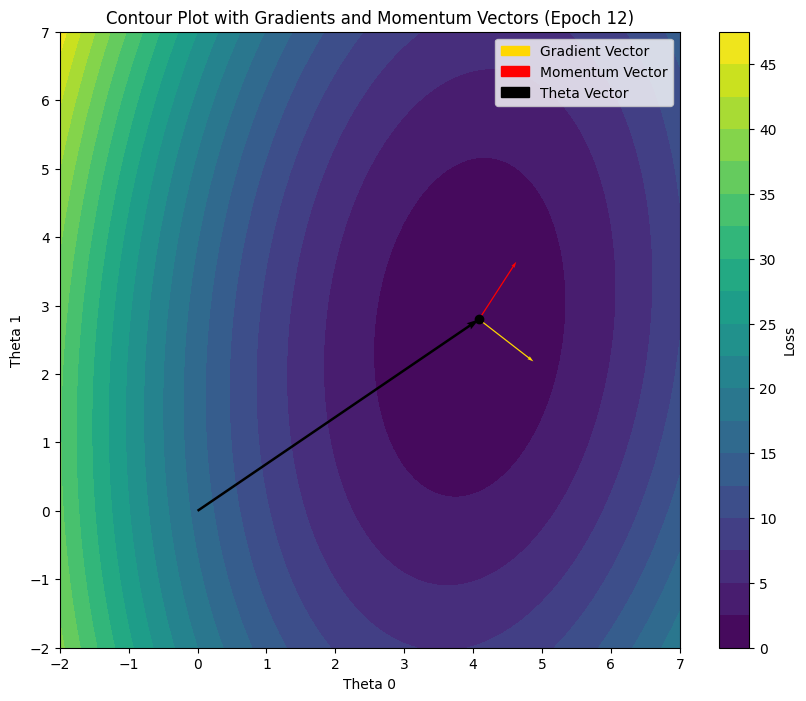

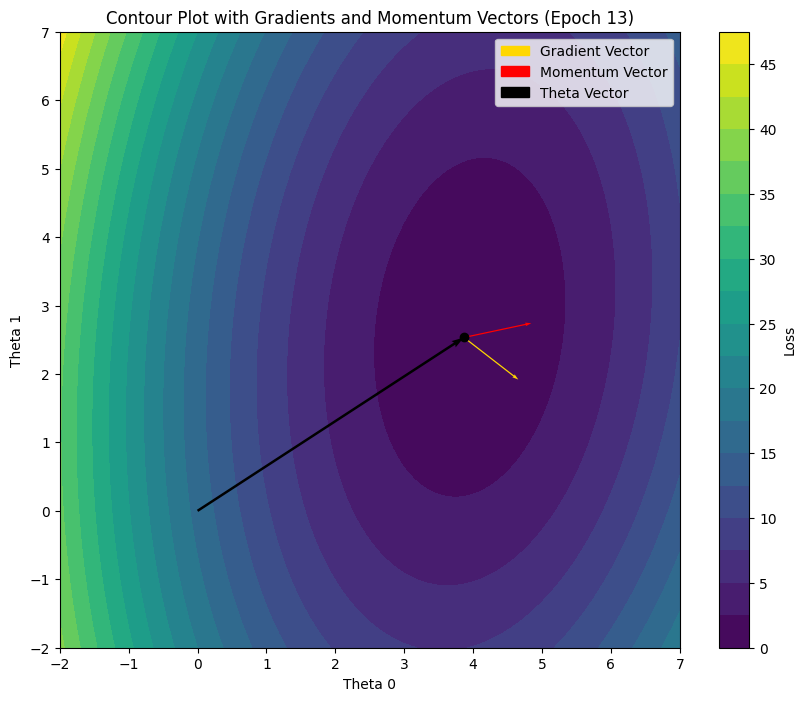

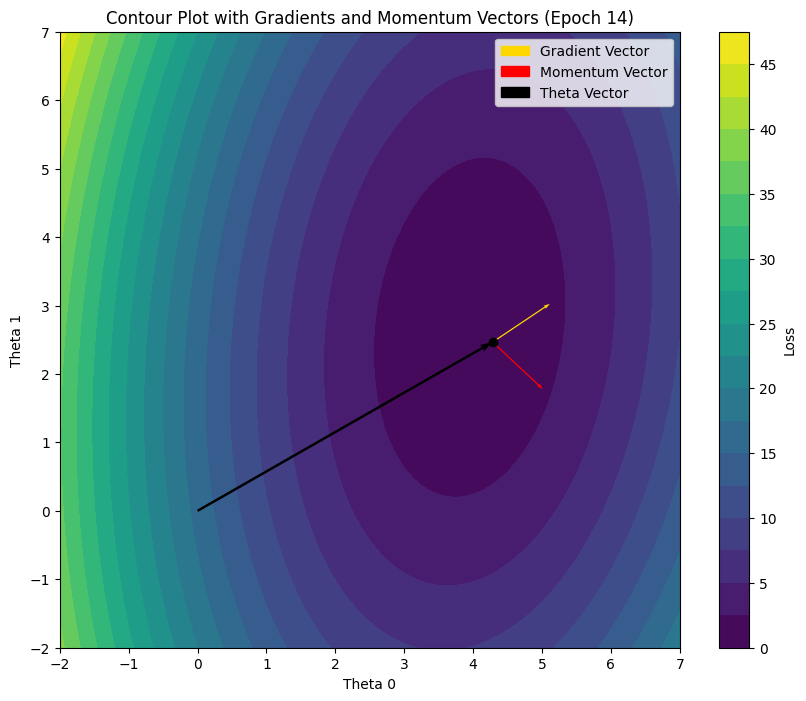

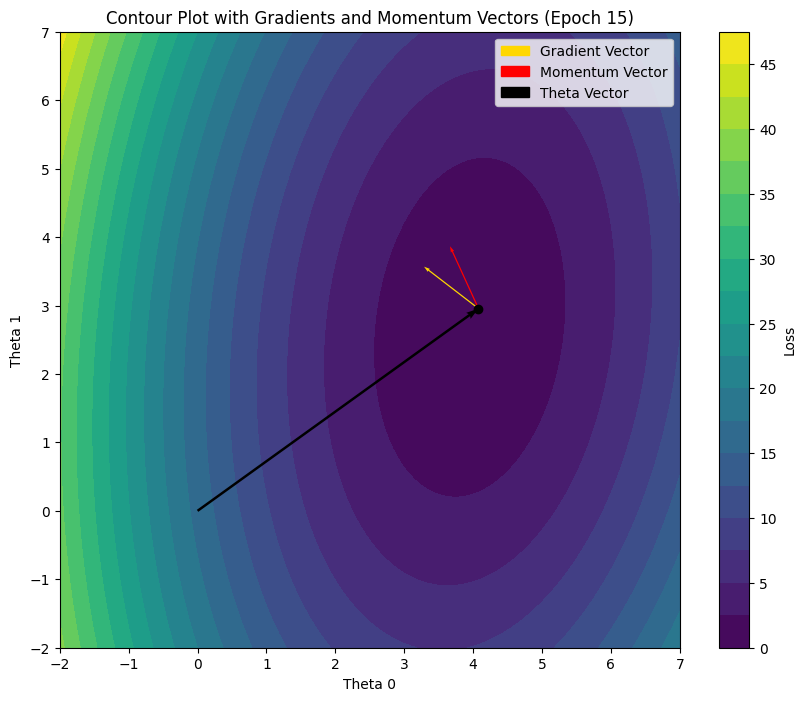

In [116]:
#For stochastic gradient descent with momentum
theta_0_history_momentum_stoch, theta_1_history_momentum_stoch, momentum_history_stoch, gradient_history_momentum_stoch, loss_history_momentum_stoch = gd_with_momentum(x1_torch, y_torch, lr=0.01, beta=0.95, epochs=150, epsilon=0.001, batch_size=1)
plot_contour_with_vectors(theta_0_history_momentum_stoch, theta_1_history_momentum_stoch, gradient_history_momentum_stoch, momentum_history_stoch, x1_torch, y_torch, model, num_epochs=15, save_dir='contour_plots_stoch')


In [117]:
print("The losses over 150 epochs for stochaistic batch gradient descent with momentum:")
for i in range(len(loss_history_momentum_stoch)):
  print(f"loss at epoch{i+1} is", loss_history_momentum_stoch[i])


The losses over 150 epochs for stochaistic batch gradient descent with momentum:
loss at epoch1 is 0.6426039934158325
loss at epoch2 is 1.3792502880096436
loss at epoch3 is 1.4561588764190674
loss at epoch4 is 0.6381772756576538
loss at epoch5 is 1.068734884262085
loss at epoch6 is 0.9985443353652954
loss at epoch7 is 0.6017208099365234
loss at epoch8 is 0.6076022386550903
loss at epoch9 is 0.6094179153442383
loss at epoch10 is 0.619820773601532
loss at epoch11 is 0.5963867902755737
loss at epoch12 is 0.6156353950500488
loss at epoch13 is 0.6076356768608093
loss at epoch14 is 0.7337579131126404
loss at epoch15 is 0.6295226812362671
loss at epoch16 is 0.6341918706893921
loss at epoch17 is 0.7127649188041687
loss at epoch18 is 1.179318904876709
loss at epoch19 is 0.8524876832962036
loss at epoch20 is 0.6206191182136536
loss at epoch21 is 0.6475284099578857
loss at epoch22 is 0.6103324294090271
loss at epoch23 is 0.6101373434066772
loss at epoch24 is 1.0516912937164307
loss at epoch25 is 

In [118]:
# losses for full batch vanilla gradient descent for lr = 0.01
theta_0_history_stoch2, theta_1_history_stoch2, loss_history_stoch2 = stochastic_gd(x1_torch, y_torch, lr = 0.01, epochs = 150)

for i in range(len(loss_history_stoch2)):
  print(f"loss at epoch{i+1} is", loss_history_stoch2[i])

loss at epoch1 is 6.753879547119141
loss at epoch2 is 3.09415602684021
loss at epoch3 is 1.8669929504394531
loss at epoch4 is 1.3230218887329102
loss at epoch5 is 1.0232126712799072
loss at epoch6 is 0.8556760549545288
loss at epoch7 is 0.754387378692627
loss at epoch8 is 0.6924296617507935
loss at epoch9 is 0.6545506715774536
loss at epoch10 is 0.6311718821525574
loss at epoch11 is 0.6180824041366577
loss at epoch12 is 0.609346866607666
loss at epoch13 is 0.603232204914093
loss at epoch14 is 0.6006033420562744
loss at epoch15 is 0.5992313623428345
loss at epoch16 is 0.5973801612854004
loss at epoch17 is 0.596713662147522
loss at epoch18 is 0.5962823033332825
loss at epoch19 is 0.5959721207618713
loss at epoch20 is 0.5967407822608948
loss at epoch21 is 0.5958261489868164
loss at epoch22 is 0.59608393907547
loss at epoch23 is 0.5958623886108398
loss at epoch24 is 0.5959384441375732
loss at epoch25 is 0.5958768129348755
loss at epoch26 is 0.5958198308944702
loss at epoch27 is 0.596028685

In my case the loss is not converging to the value given in the question for


both the methods. The losses by stochastic gradient descent by momentum overall are little lesser than the losses by stochastic vanilla gradient descent. The fluctuations in the losses for stochastic gradient descent by momentum are smaller when compared to the fluctuations in the losses by stochastic vanilla gradient descent. Both of them donot converge to the value provided in the question.

But overall stochastic gradient descent by momentum converges faster than stochastic vanilla gradient descent.

Momentum accumulates gradients over time, effectively calculating an average. This indicates that the update direction is influenced by both the current and earlier gradients. As a result, updates are smoother, reducing unexpected oscillations. Momentum provides inertia to reduce oscillations in situations where the gradient changes rapidly (such as near steep cliffs ). Instead of making significant changes in direction, the optimizer will stick with the previous path, resulting in smaller oscillations. Because momentum helps the optimizer to gain speed in the desired direction, it can converge more quickly in flat areas.  It allows for more updates in directions with steady gradients while reducing updates in directions with quickly changing gradients, thereby smoothing out the optimization trajectory.